In [2]:
import os
import collections

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import exposure, img_as_float
plt.style.use('dark_background')
%matplotlib inline

In [3]:
IMAGE_DIMENSIONS_NUM = 3

In [4]:
images_dir = '../input/train/images/'
images_masks_dir = '../input/train/masks/'
full_cwd_path = os.getcwd()
path_prefix, cwd_itself = os.path.split(full_cwd_path)
if cwd_itself != 'code':
    os.chdir(os.path.join(path_prefix, 'code'))
    print(os.getcwd())
train_images_names = os.listdir(images_dir)
train_images_masks_names = os.listdir(images_masks_dir)
#print(train_images)
#print(train_images_masks)
print("train_images_names len: {}".format(len(train_images_names)))
print("train_images_masks_names len: {}".format(len(train_images_masks_names)))
print(train_images_names[:10]) # Is an image name and mask name with the same index math?
print(train_images_masks_names[:10])
depths_df = pd.read_csv('../input/depths.csv')
print(depths_df.head())
print(depths_df.shape)

train_images_names len: 4000
train_images_masks_names len: 4000
['2010b17cf6.png', '3f5adbdcc7.png', '1d7a812c76.png', '9b1f59b89c.png', '4d33311a1e.png', '1f50bc7a9f.png', '5d0a9c5b0e.png', '51846d4c96.png', 'aac747667e.png', '23c72b10cb.png']
['2010b17cf6.png', '3f5adbdcc7.png', '1d7a812c76.png', '9b1f59b89c.png', '4d33311a1e.png', '1f50bc7a9f.png', '5d0a9c5b0e.png', '51846d4c96.png', 'aac747667e.png', '23c72b10cb.png']
           id    z
0  4ac19fb269  306
1  1825fadf99  157
2  f59821d067  305
3  5b435fad9d  503
4  e340e7bfca  783
(22000, 2)


In [5]:
train_images = [mpimg.imread(os.path.join(images_dir, image_name)) for image_name in train_images_names]
train_images_masks = [mpimg.imread(os.path.join(images_masks_dir, mask_name)) for mask_name in train_images_masks_names]

In [6]:
print(train_images[0])
print(train_images_masks[0])

[[[0.24705882 0.24705882 0.24705882]
  [0.21960784 0.21960784 0.21960784]
  [0.28235295 0.28235295 0.28235295]
  ...
  [0.35686275 0.35686275 0.35686275]
  [0.29411766 0.29411766 0.29411766]
  [0.2627451  0.2627451  0.2627451 ]]

 [[0.38039216 0.38039216 0.38039216]
  [0.33333334 0.33333334 0.33333334]
  [0.34901962 0.34901962 0.34901962]
  ...
  [0.34901962 0.34901962 0.34901962]
  [0.34117648 0.34117648 0.34117648]
  [0.39215687 0.39215687 0.39215687]]

 [[0.5411765  0.5411765  0.5411765 ]
  [0.5137255  0.5137255  0.5137255 ]
  [0.5254902  0.5254902  0.5254902 ]
  ...
  [0.36078432 0.36078432 0.36078432]
  [0.38039216 0.38039216 0.38039216]
  [0.47058824 0.47058824 0.47058824]]

 ...

 [[0.45882353 0.45882353 0.45882353]
  [0.5137255  0.5137255  0.5137255 ]
  [0.5372549  0.5372549  0.5372549 ]
  ...
  [0.54509807 0.54509807 0.54509807]
  [0.5686275  0.5686275  0.5686275 ]
  [0.57254905 0.57254905 0.57254905]]

 [[0.39215687 0.39215687 0.39215687]
  [0.39607844 0.39607844 0.39607844]


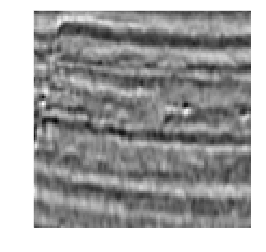

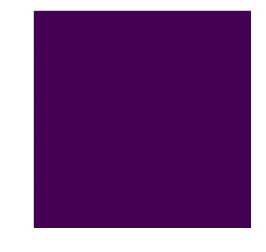

In [7]:
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_images_masks[0])
plt.show()

In [8]:
def show_paired_images_grid(paired_images_list, columns_num, figsize):
    rows_num = 2 * len(paired_images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    paired_images_list_len = len(paired_images_list)
    slice_len = columns_num
    paired_images_list_slices_len = paired_images_list_len // slice_len
    paired_images_list_slices = [
        paired_images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(paired_images_list_slices_len)
    ]
    for i in range(ax.shape[0] // 2):
        paired_images_list_slice = paired_images_list_slices[i]
        images_list_0 = [images_pair[0] for images_pair in paired_images_list_slice]
        images_list_1 = [images_pair[1] for images_pair in paired_images_list_slice]
        for j in range(columns_num):
            ax[2 * i, j].imshow(images_list_0[j])
            ax[2 * i + 1, j].imshow(images_list_1[j])
    plt.show()

In [9]:
def draw_images_with_histograms(images_list, columns_num, figsize, nbins):
    rows_num = 3 * len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_list_slices = [
    images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    for i in range(ax.shape[0] // 3):
        images_list_slice = images_list_slices[i]
        for j in range(columns_num):
            ax[3 * i, j].imshow(images_list_slice[j])
            img_cdf, cdf_bins = exposure.cumulative_distribution(images_list_slice[j].flatten())
            ax[3 * i + 1, j].hist(exposure.histogram(images_list_slice[j].flatten(), nbins=nbins))
            ax[3 * i + 2, j].plot(cdf_bins, img_cdf, color='green')
    plt.show()

In [10]:
paired_images_list = list(zip(train_images[:40], train_images_masks[:40]))

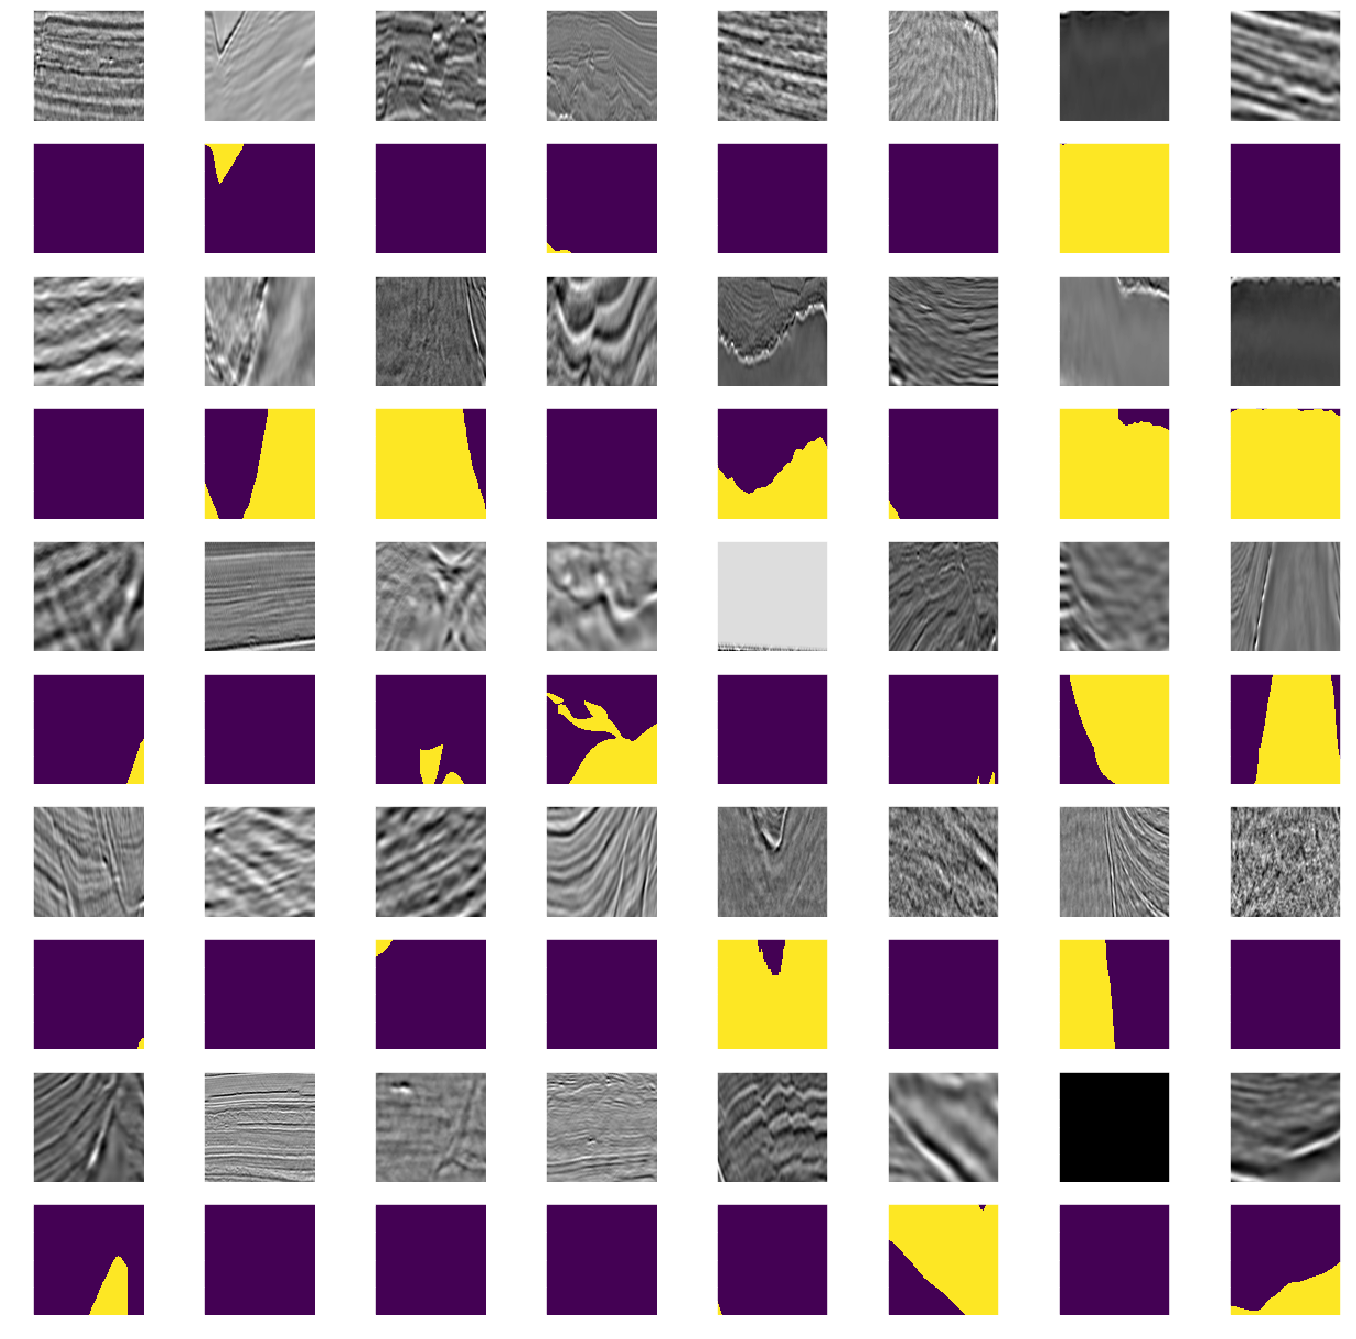

In [11]:
show_paired_images_grid(paired_images_list, 8, (24, 24))

In [12]:
for train_image, train_mask in tuple(zip(train_images, train_images_masks))[:40]:
    print(train_image.shape, train_mask.shape)

(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)
(101, 101, 3) (101, 101)


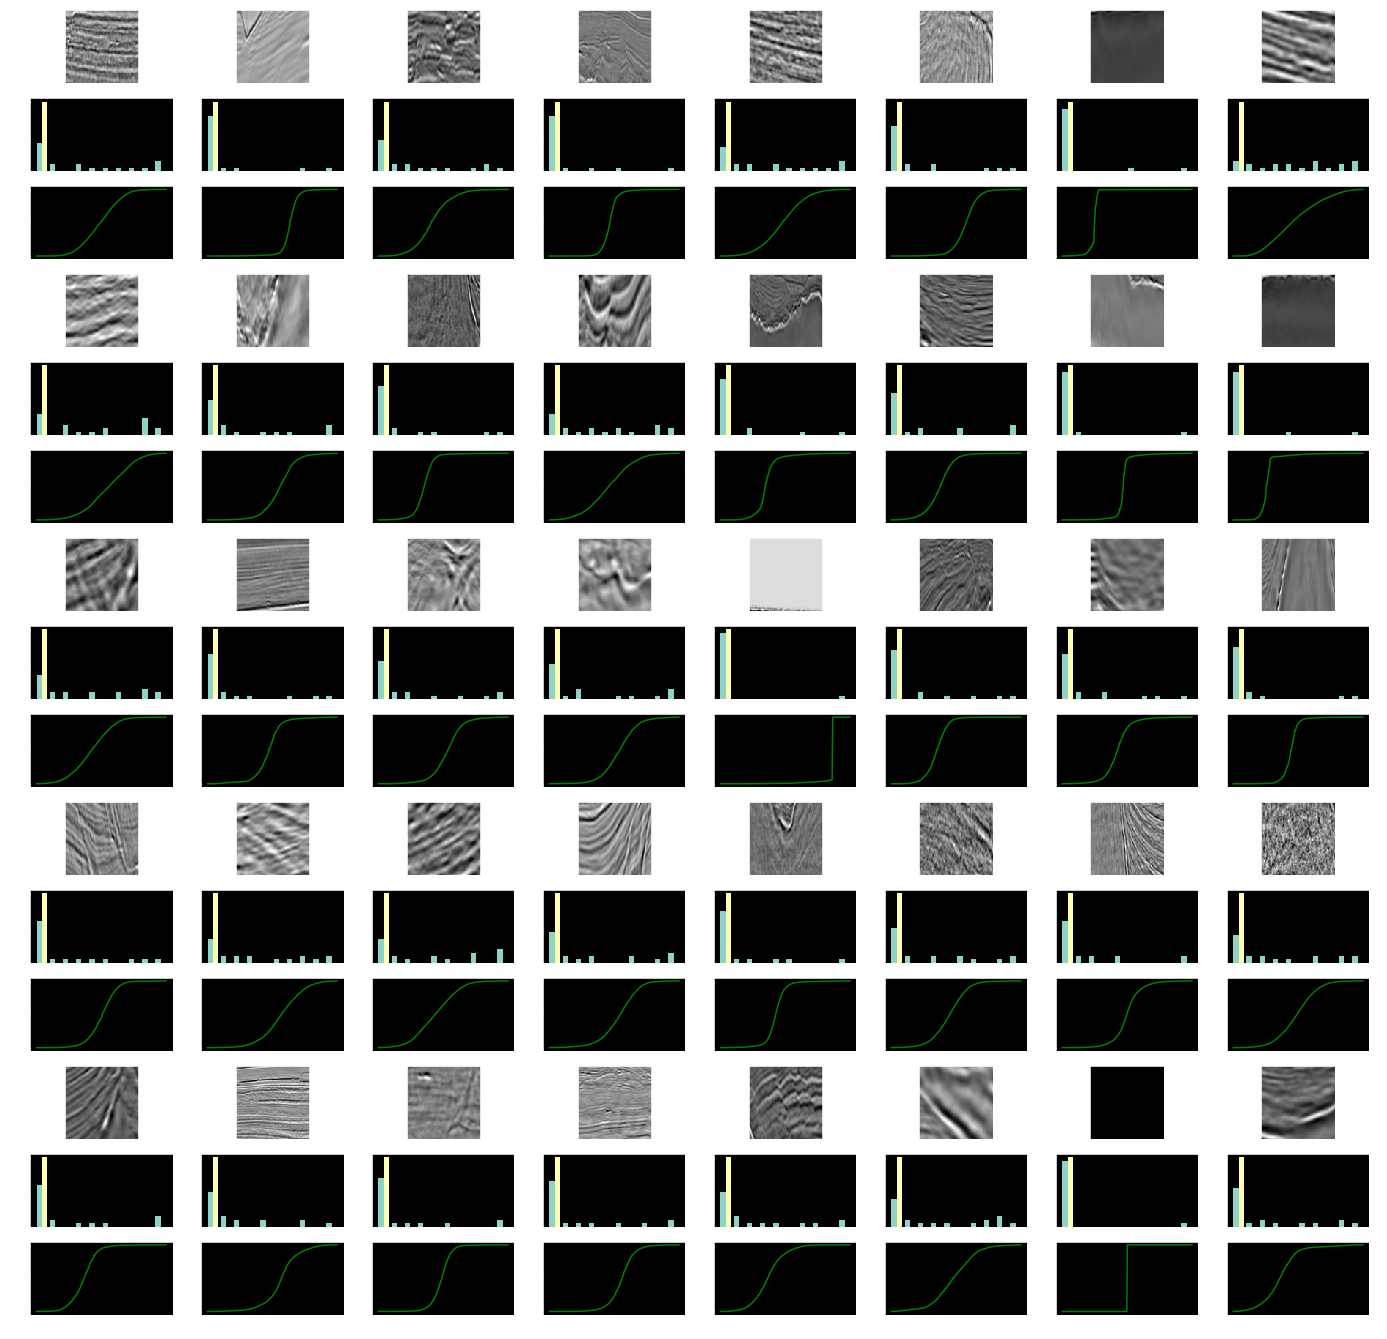

In [13]:
draw_images_with_histograms(train_images[:40], 8, (24, 24), 20)

In [14]:
#for row in depths_df.iterrows():
#    print(type(row))
print(depths_df.columns)
images_descriptions = []
for image_name, image, mask in zip(train_images_names, train_images, train_images_masks):
    images_descriptions.append(
        [image_name[:-len('.png')], image, mask, depths_df[depths_df['id'] == image_name[:-len('.png')]]['z'].values[0]]
    )

Index(['id', 'z'], dtype='object')


In [15]:
images_descriptions = tuple(images_descriptions)

In [16]:
for image_description in images_descriptions[:40]:
    print(image_description, type(image_description[3]), image_description[3].shape)

['2010b17cf6', array([[[0.24705882, 0.24705882, 0.24705882],
        [0.21960784, 0.21960784, 0.21960784],
        [0.28235295, 0.28235295, 0.28235295],
        ...,
        [0.35686275, 0.35686275, 0.35686275],
        [0.29411766, 0.29411766, 0.29411766],
        [0.2627451 , 0.2627451 , 0.2627451 ]],

       [[0.38039216, 0.38039216, 0.38039216],
        [0.33333334, 0.33333334, 0.33333334],
        [0.34901962, 0.34901962, 0.34901962],
        ...,
        [0.34901962, 0.34901962, 0.34901962],
        [0.34117648, 0.34117648, 0.34117648],
        [0.39215687, 0.39215687, 0.39215687]],

       [[0.5411765 , 0.5411765 , 0.5411765 ],
        [0.5137255 , 0.5137255 , 0.5137255 ],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        ...,
        [0.36078432, 0.36078432, 0.36078432],
        [0.38039216, 0.38039216, 0.38039216],
        [0.47058824, 0.47058824, 0.47058824]],

       ...,

       [[0.45882353, 0.45882353, 0.45882353],
        [0.5137255 , 0.5137255 , 0.5137255 ],
       

In [17]:
print(depths_df['z'].head())

0    306
1    157
2    305
3    503
4    783
Name: z, dtype: int64


In [18]:
for image_description in images_descriptions:
    dims = image_description[1].shape
    pixel_matrix = np.reshape(image_description[1], (dims[0] * dims[1], dims[2]))
    image_description.append(pixel_matrix)
    #print(image_description[4].shape)

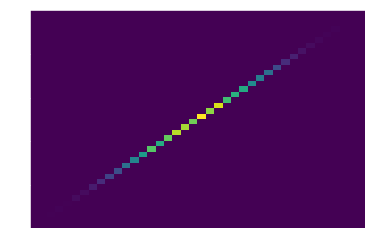

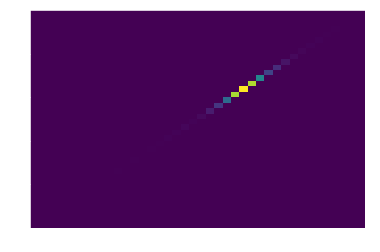

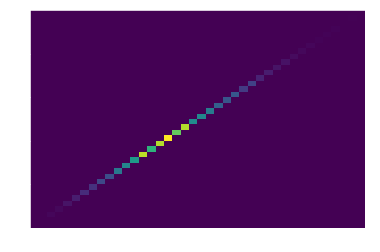

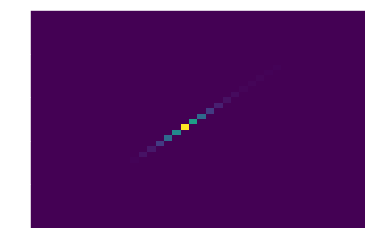

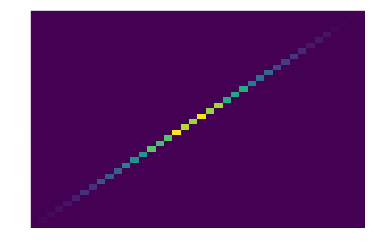

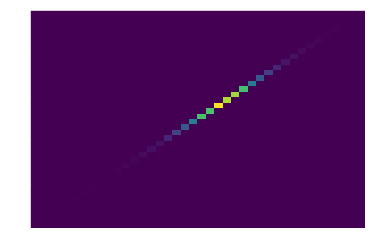

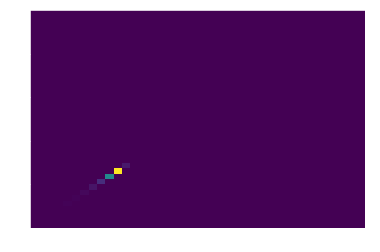

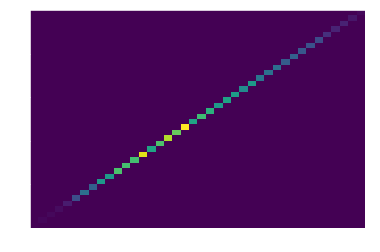

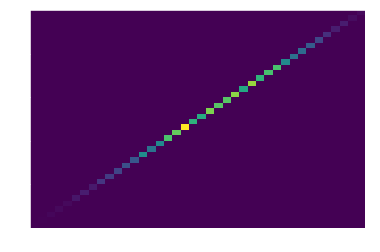

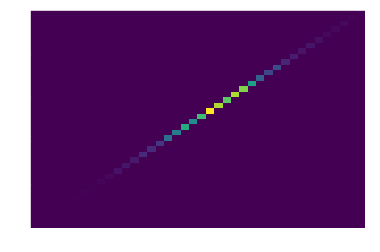

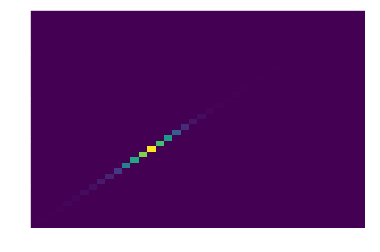

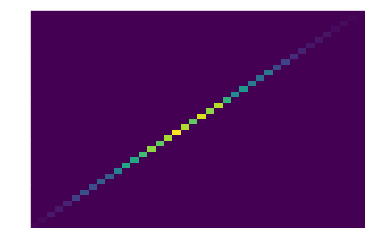

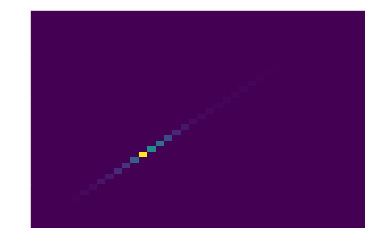

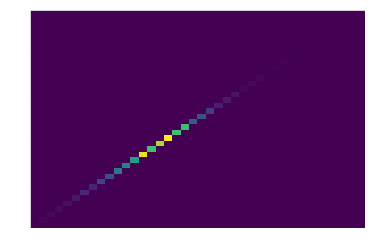

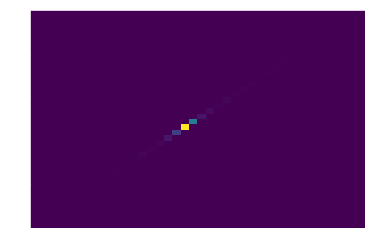

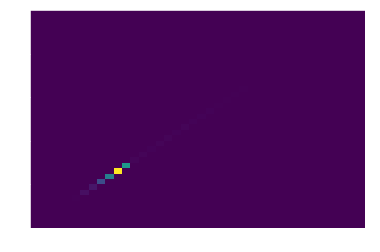

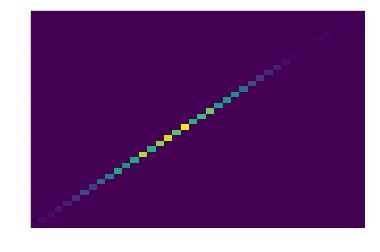

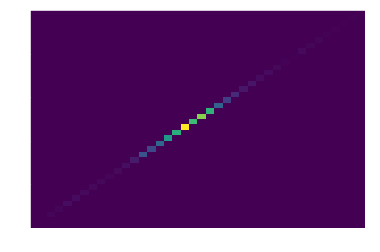

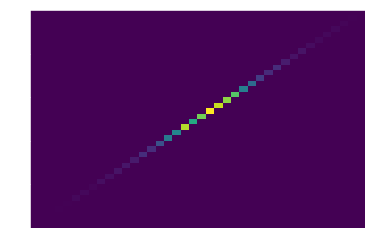

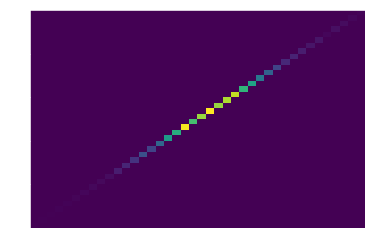

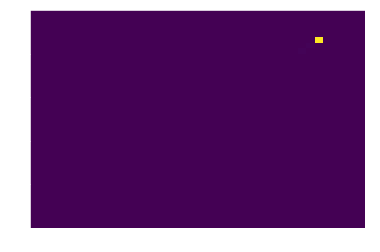

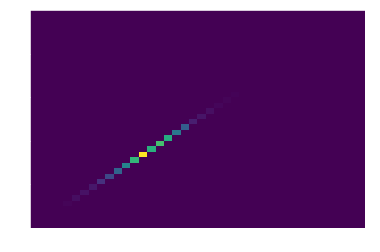

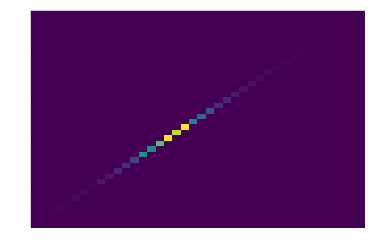

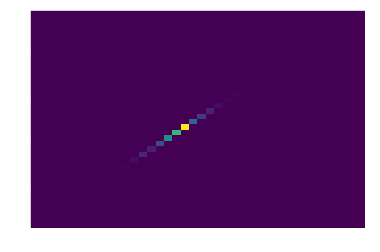

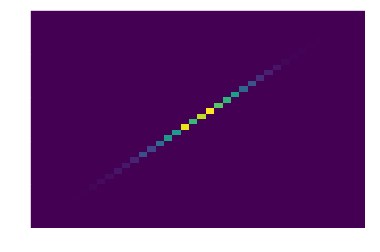

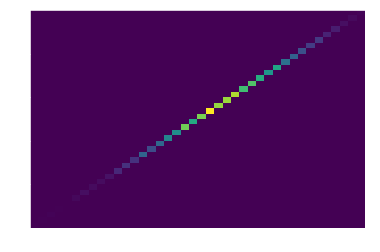

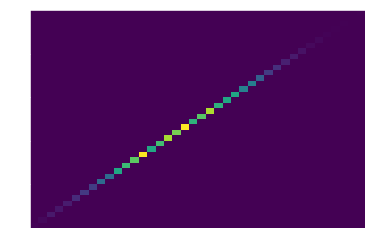

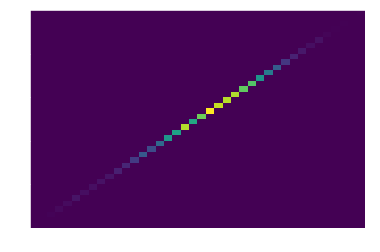

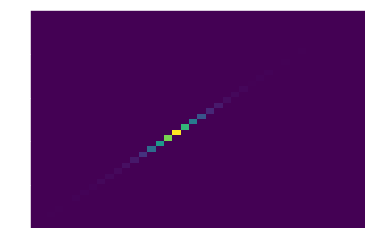

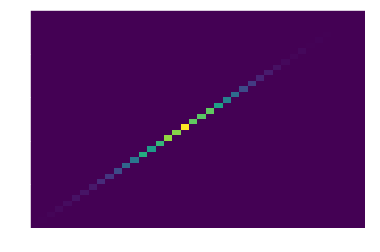

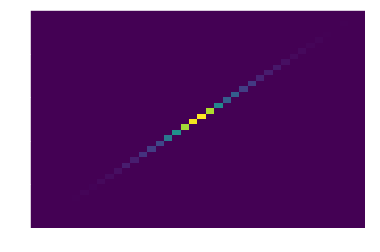

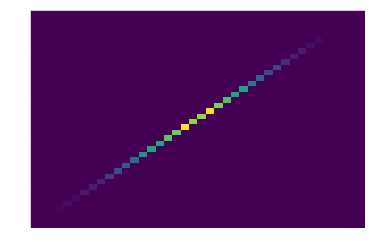

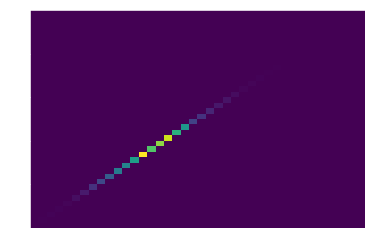

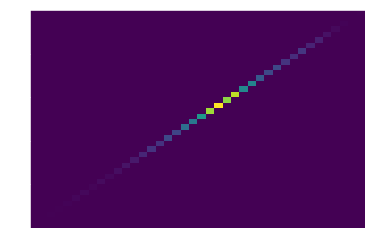

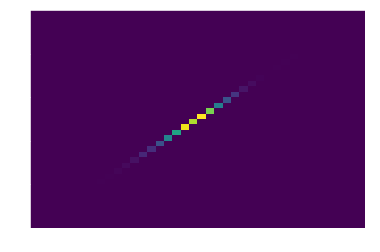

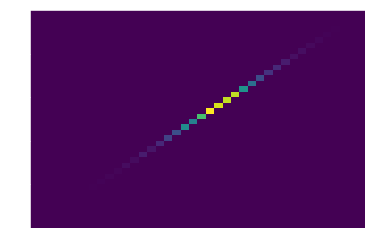

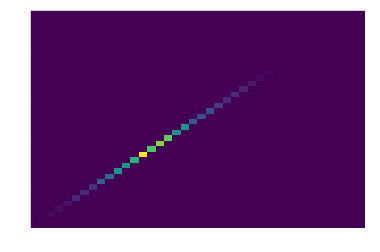

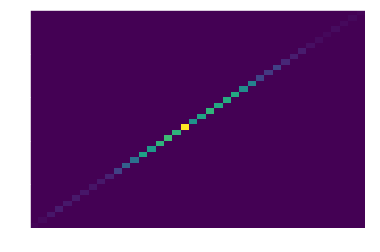

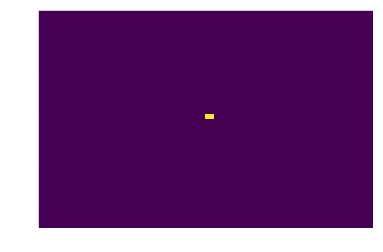

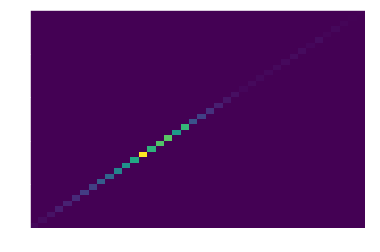

In [19]:
for image_description in images_descriptions[:40]:
    plt.hist2d(image_description[4][:, 1], image_description[4][:, 2], bins=(40, 40))
    #plt.hist(image_description[4][:, 1], image_description[4][:, 2], bins=40)
    plt.show()

In [20]:
images_descriptions_dict = {}
for image_description in images_descriptions:
    depth = image_description[3]
    if depth in images_descriptions_dict:
        images_descriptions_dict[depth].append(image_description)
    else:
        images_descriptions_dict[depth] = [image_description]

In [21]:
sorted_depths = sorted(images_descriptions_dict.keys())
print(len(sorted_depths))

839


In [22]:
images_depth_list = [(depth, images_descriptions_dict[depth]) for depth  in sorted(images_descriptions_dict)]

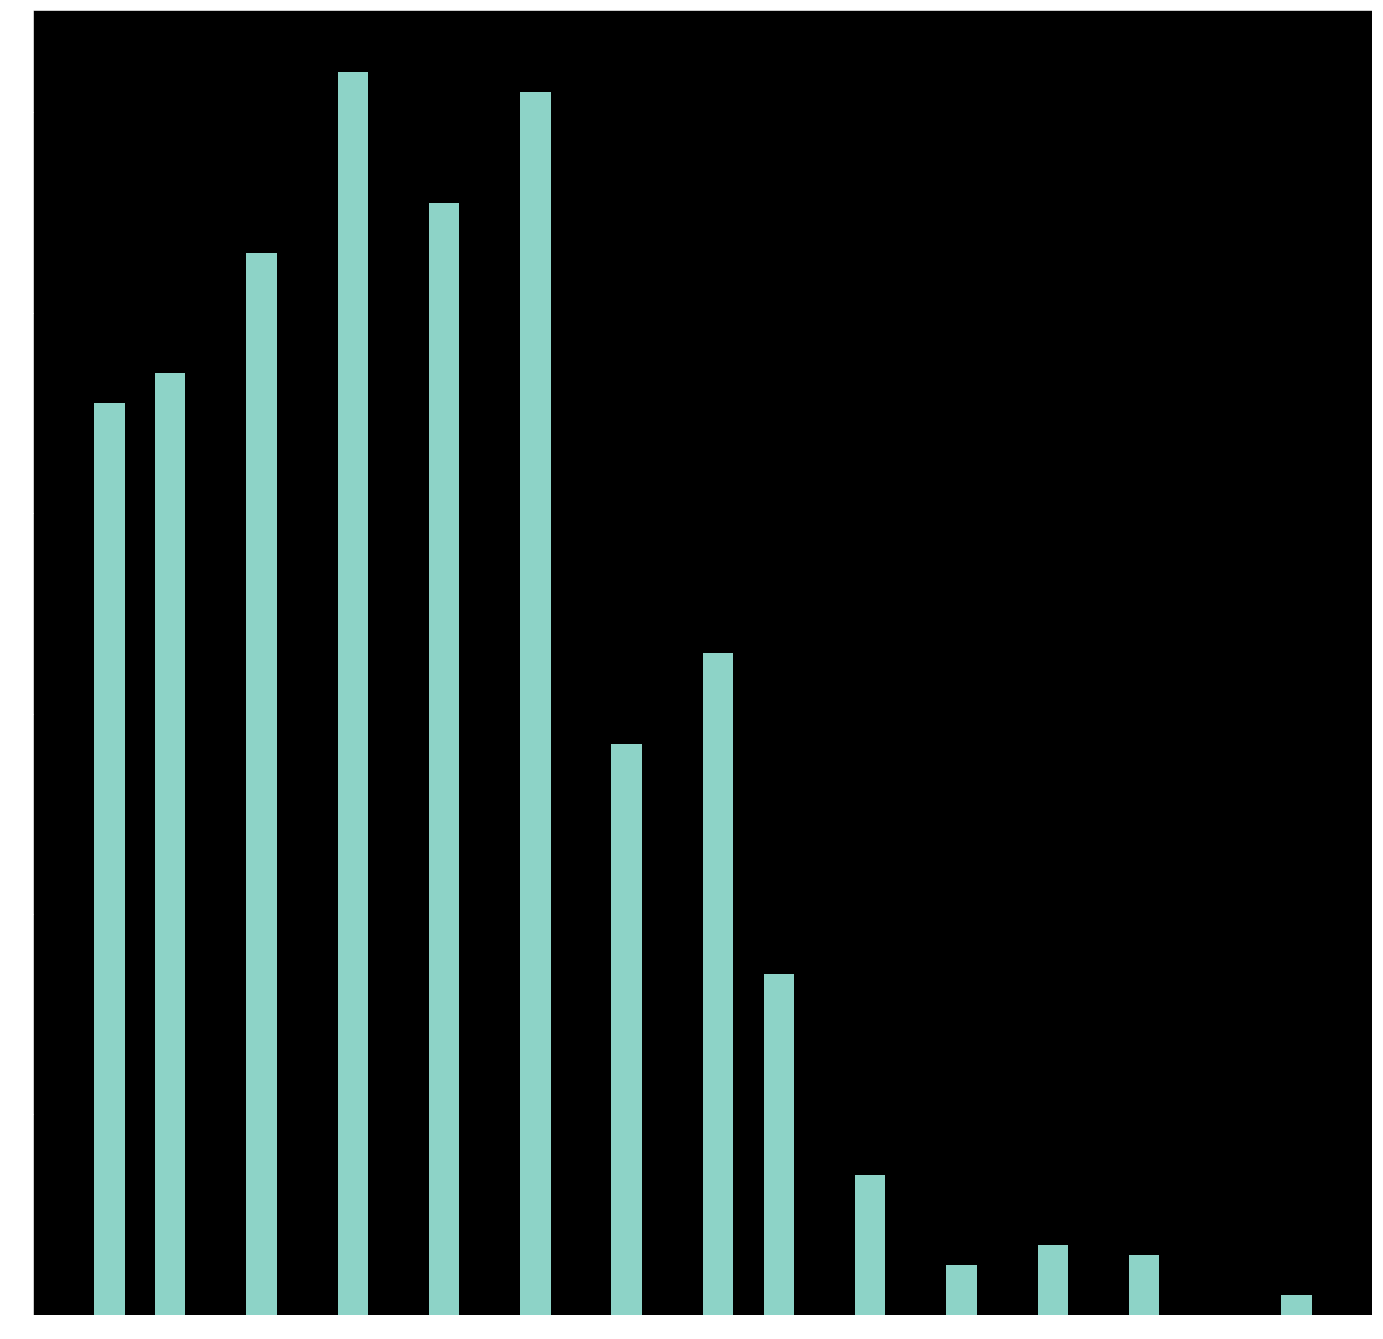

In [23]:
depths = [record[0] for record in images_depth_list]
num_of_images = [len(record[1]) for record in images_depth_list]
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(num_of_images, bins=40)
plt.show()

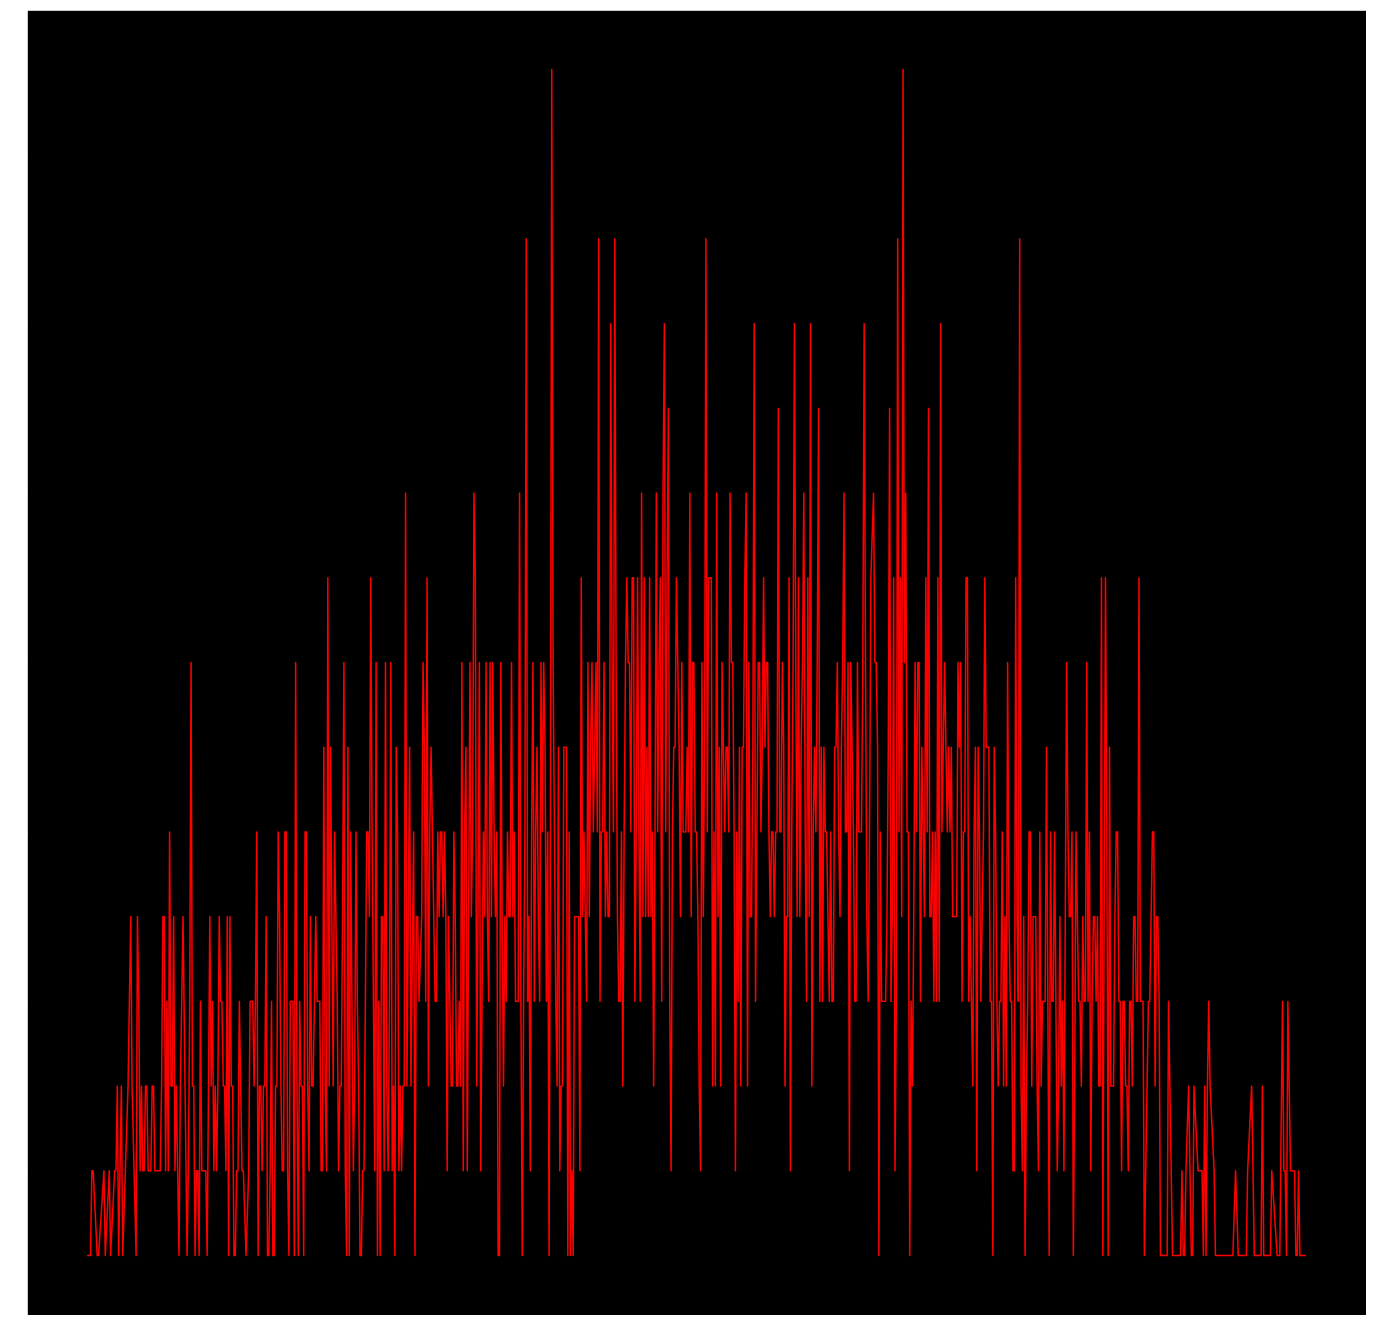

In [24]:
depths = [record[0] for record in images_depth_list]
num_of_images = [len(record[1]) for record in images_depth_list]
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.plot(depths, num_of_images, color='r')
plt.show()

In [25]:
def extract_salt_pixels_by_mask(image, mask):
    return image * mask
apply_mask_to_color_channel = extract_salt_pixels_by_mask

In [26]:
def extract_not_salt_pixels_by_mask(image, mask):
    #return image * (np.ones(mask.shape) - mask)
    non_salt_pixels = image * (np.ones(mask.shape) - mask)
    #print("extract_non_salt_pixels_by_mask:\n", non_salt_pixels)
    return non_salt_pixels
apply_negative_mask_to_color_channel = extract_not_salt_pixels_by_mask

In [27]:
def get_mask_complement(mask):
    return np.ones(mask.shape) - mask

In [28]:
def compute_salt_pixels_num(mask):
    return mask.sum()

def compute_non_salt_pixels_num(mask):
    return mask.size - mask.sum()

In [29]:
def compute_whole_image_mean_brightnes(image):
    return image.mean()

In [30]:
def compute_salt_pixels_mean_brightness(image, mask):
    full_color_image_salt_pixels = apply_mask_to_full_color_image(image, mask)
    #print(compute_salt_pixels_num(mask))
    salt_pixels_num = compute_salt_pixels_num(mask) * IMAGE_DIMENSIONS_NUM
    salt_pixels_sum = full_color_image_salt_pixels.sum()
    return 0.0 if salt_pixels_num == 0 else salt_pixels_sum / salt_pixels_num

def compute_non_salt_pixels_mean_brightness(image, mask):
    full_color_image_non_salt_pixels = apply_negative_mask_to_full_color_image(image, mask)
    return full_color_image_non_salt_pixels.sum() / (IMAGE_DIMENSIONS_NUM * compute_non_salt_pixels_num(mask))

In [31]:
def get_image_color_channels(image):
    return [image[:, :, i] for i in range(IMAGE_DIMENSIONS_NUM)]

def collapse_color_channels_to_image(color_components):
    return np.array([color_components[i].T for i in range(IMAGE_DIMENSIONS_NUM)]).T

In [32]:
def get_images_color_channels(images):
    return [get_image_color_channels(image) for image in images]

In [33]:
def apply_mask_to_color_channels(color_channels, mask):
    return [apply_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [34]:
def apply_negative_mask_to_color_channels(color_channels, mask):
    #print("apply_negative_mask_to_color_channels, color_channels:\n", color_channels)
    return [apply_negative_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [35]:
def apply_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [36]:
def apply_negative_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_negative_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [37]:
images_mean_brightness = [
    compute_whole_image_mean_brightnes(image_description[1]) for image_description in images_descriptions
]

In [38]:
print(images_mean_brightness[:10])

[0.49615324, 0.63921916, 0.41947907, 0.46916816, 0.4803916, 0.5724053, 0.24768737, 0.47335577, 0.5577447, 0.56037146]


In [39]:
salt_regions_mean_brightness = [
    compute_salt_pixels_mean_brightness(image_description[1], image_description[2])
    for image_description in images_descriptions
]

In [40]:
non_salt_regions_mean_brightness = [
    compute_non_salt_pixels_mean_brightness(image_description[1], image_description[2])
    for image_description in images_descriptions
]

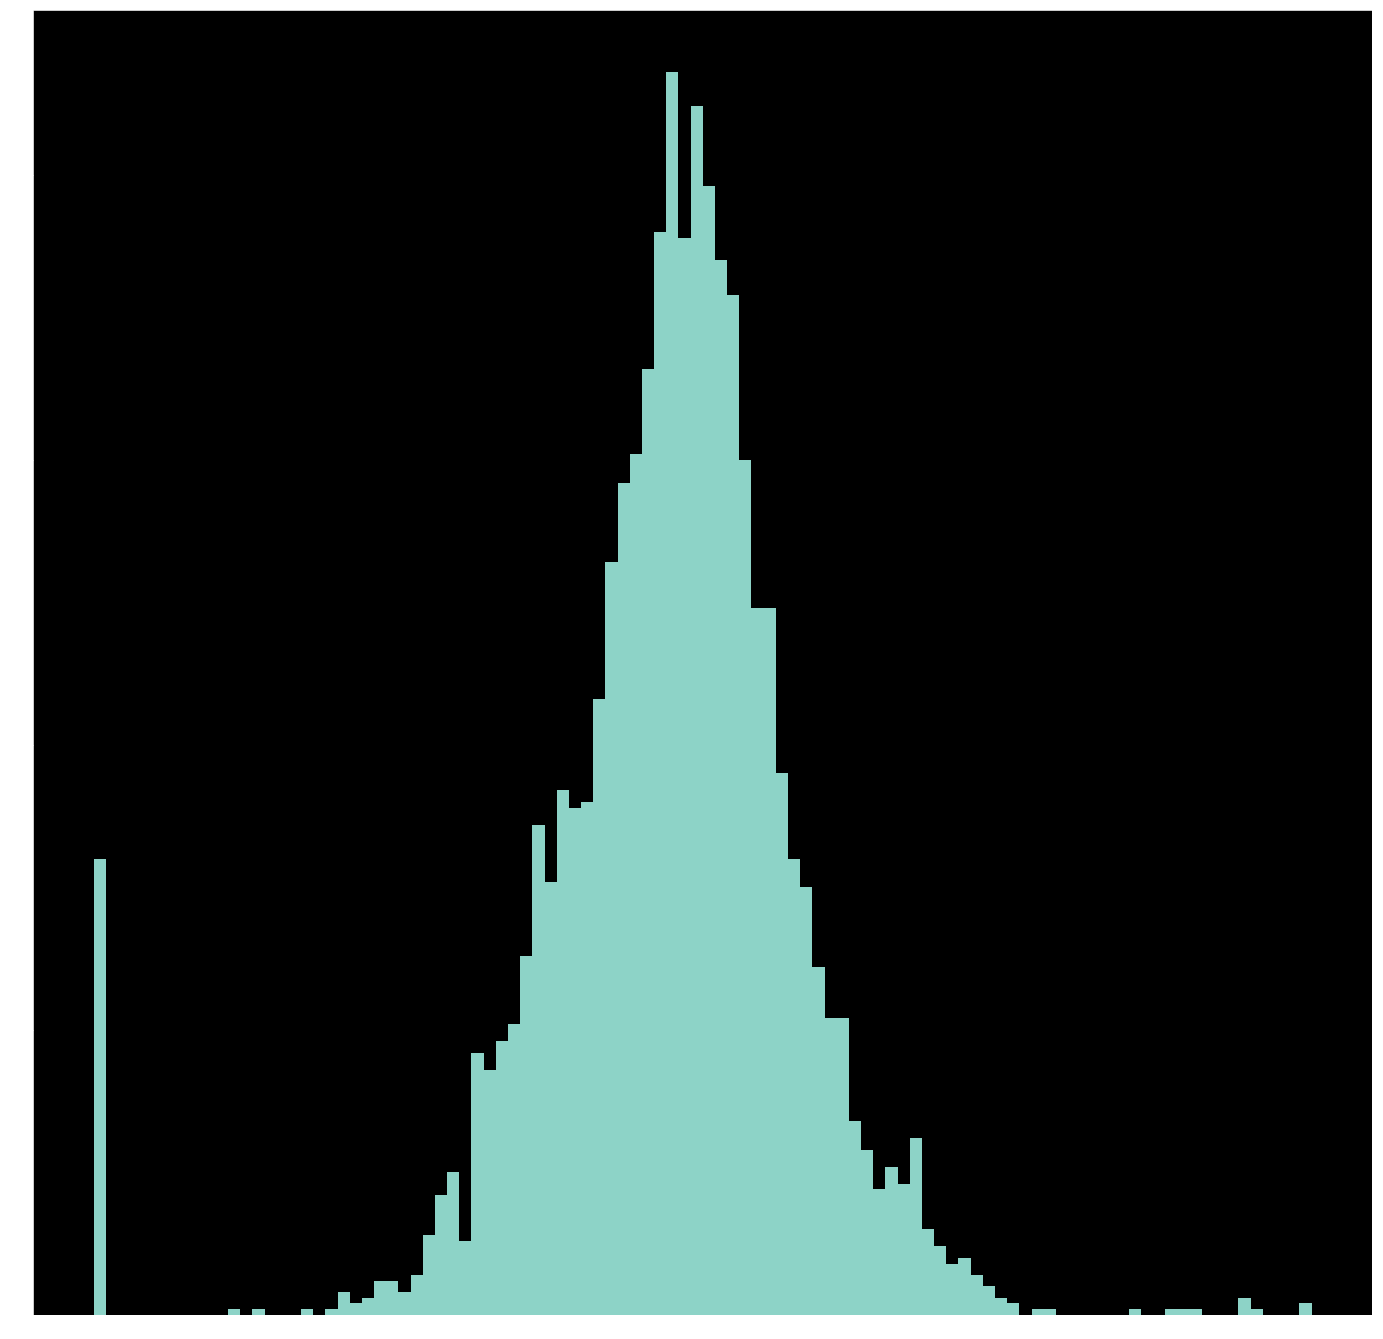

In [41]:
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(images_mean_brightness, bins=100)
plt.show()

In [42]:
'''
salt_images_parts_mean_brightness = [
    compute_salt_pixels_mean_brightness(image_description[1], image_description[2]) for image_description in images_descriptions
]
'''

'\nsalt_images_parts_mean_brightness = [\n    compute_salt_pixels_mean_brightness(image_description[1], image_description[2]) for image_description in images_descriptions\n]\n'

In [43]:
image = images_descriptions[0][1]

In [44]:
image.shape

(101, 101, 3)

In [45]:
color_components = get_image_color_channels(image)

In [46]:
collapsed_image_color_components = collapse_color_channels_to_image(color_components)

In [47]:
#image == collapsed_image_color_components

In [48]:
print(min(salt_regions_mean_brightness))
print(max(salt_regions_mean_brightness))

0.0
0.975163459777832


In [49]:
print(salt_regions_mean_brightness[:20])
#print(non_salt_regions_mean_brightness[:20])

[0.0, 0.6338659485774254, 0.0, 0.547593608047023, 0.0, 0.0, 0.24655049571999083, 0.0, 0.0, 0.5565925662878788, 0.35608900887465017, 0.0, 0.3628066878837125, 0.5181968427521417, 0.4753612383686768, 0.2643523138512674, 0.4046285566589642, 0.0, 0.5493885413840147, 0.569680655715812]


In [50]:
compute_salt_pixels_mean_brightness(images_descriptions[0][1], images_descriptions[0][2])

0.0

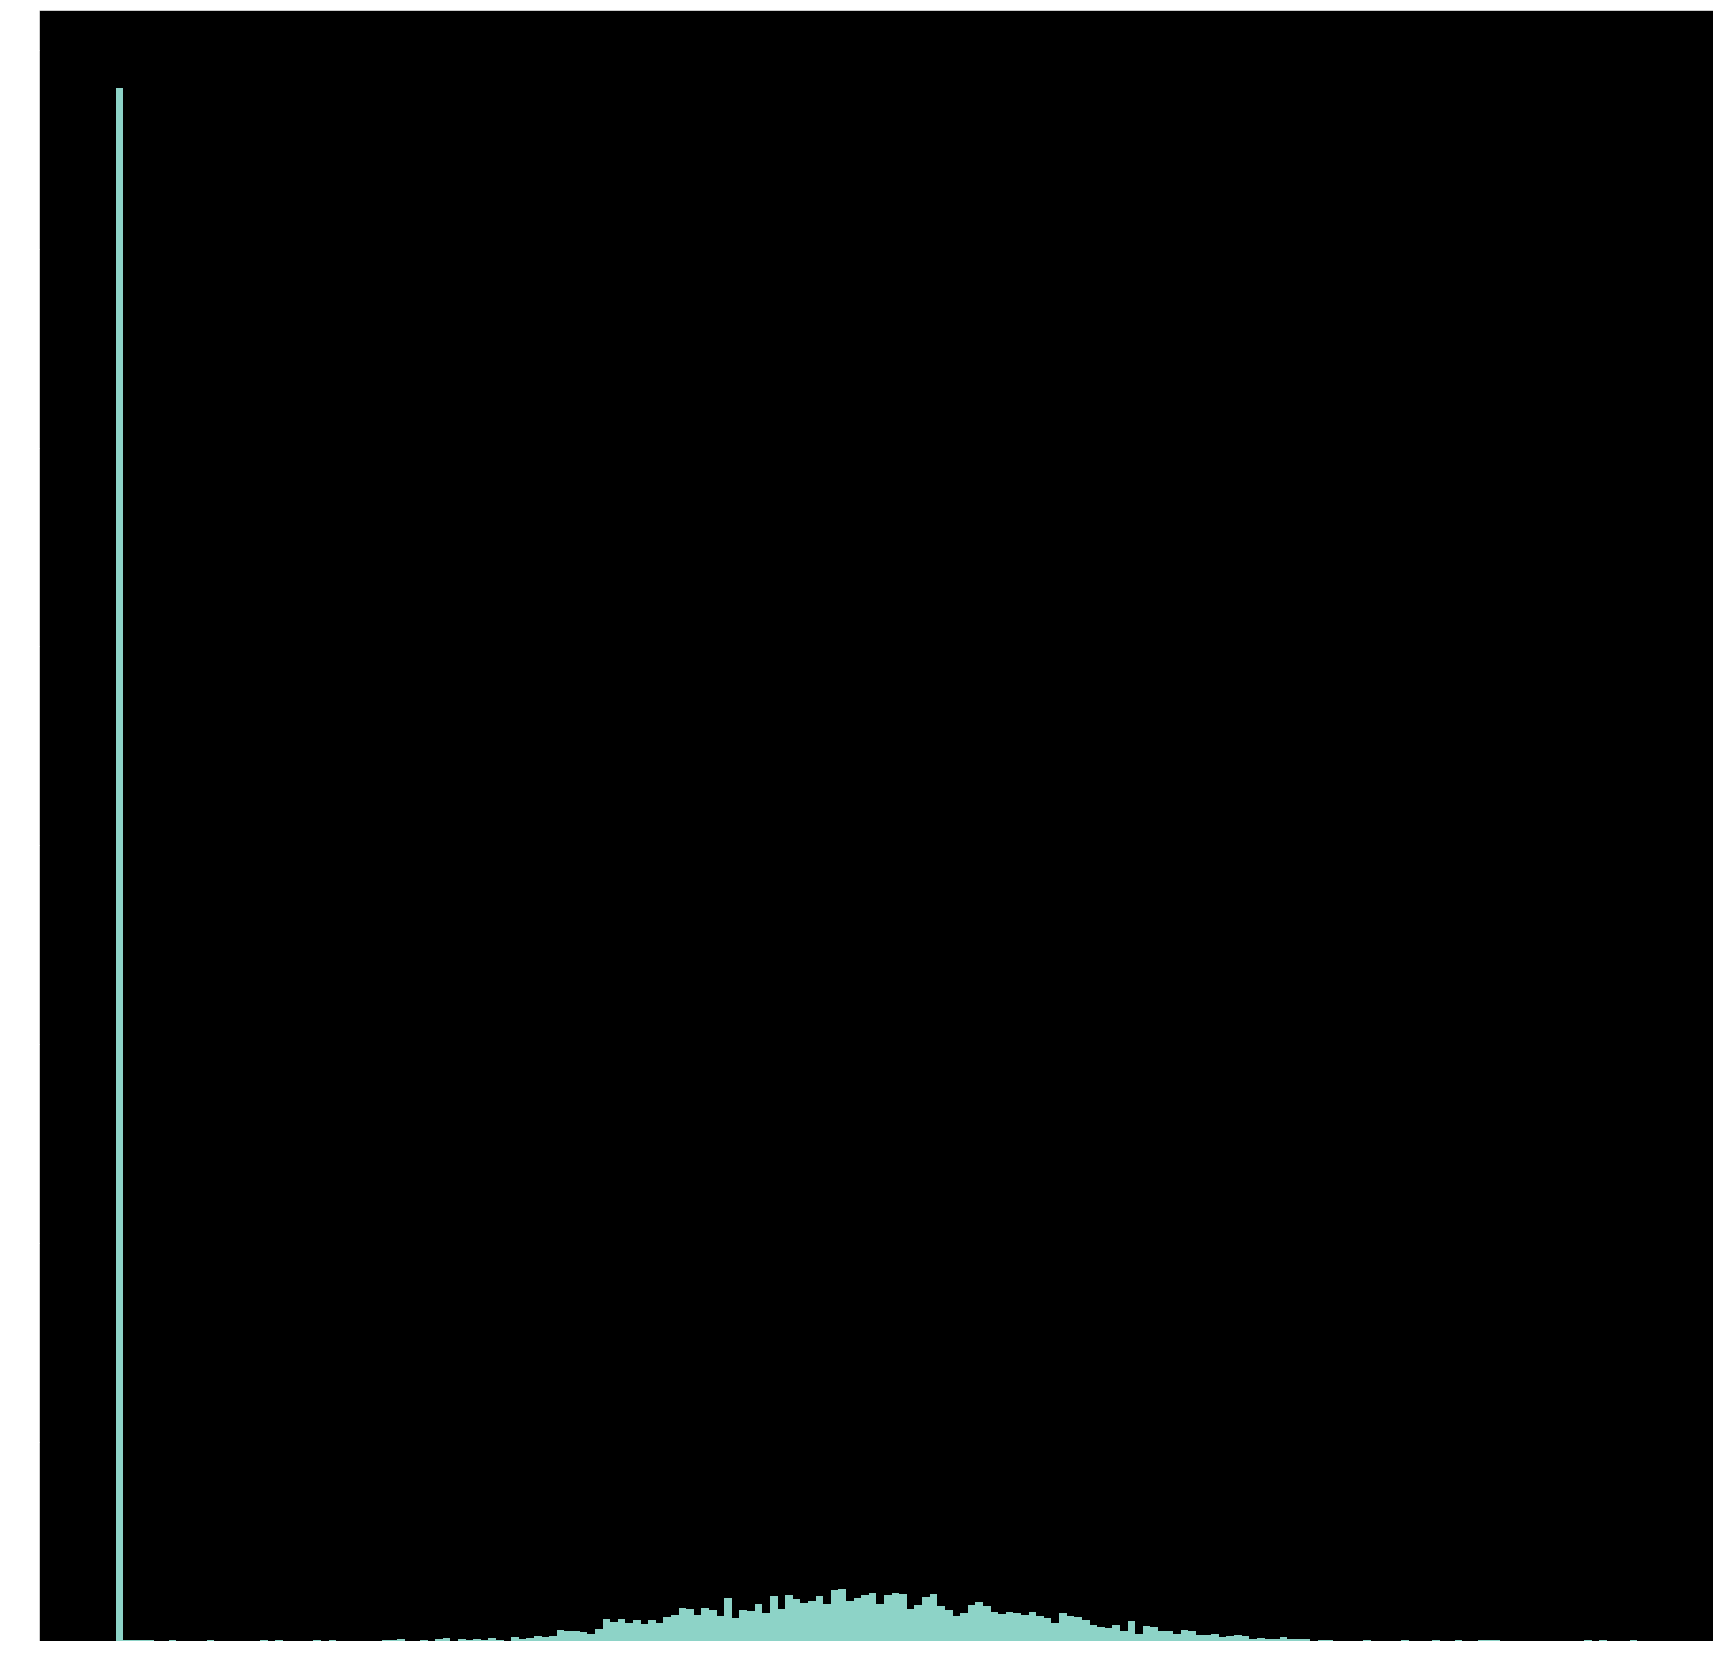

In [51]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(salt_regions_mean_brightness, bins=200)
plt.show()

In [52]:
print(non_salt_regions_mean_brightness)

[0.4961532173608802, 0.6395954795425257, 0.4194790697797626, 0.4684857274489001, 0.4803915936067085, 0.5724052629766716, 0.8908496797084808, 0.47335575755215203, 0.5577446413307223, 0.564792656661042, 0.3713715338084143, 0.46093098656326875, 0.35354282874500625, 0.373749119721387, 0.44257624021255665, 0.4337088148908835, 0.4273418608975617, 0.4723108776650301, 0.5320150266077318, 0.5262858756638523, 0.8569317585810122, 0.35153896890201225, 0.4338223613608545, 0.4465118437605665, 0.507682730584524, 0.5745196231032745, 0.44171512159334825, 0.5405894627693922, 0.45040684033717426, 0.45104421994594734, 0.5060600667899904, 0.49605634106583685, 0.3681021400781835, 0.572672824504517, 0.48734746730736034, 0.5600888997154947, 0.3721679047765765, 0.5308606333186474, 0.0, 0.3556271702071049, 0.514414403740959, 0.4805592041257789, 0.45552370392591063, 0.542876385784606, 0.40604143982995194, 0.5187803926024409, 0.5172549556771803, 0.5386634749749217, 0.45699009426898884, 0.31292682839460234, 0.4719

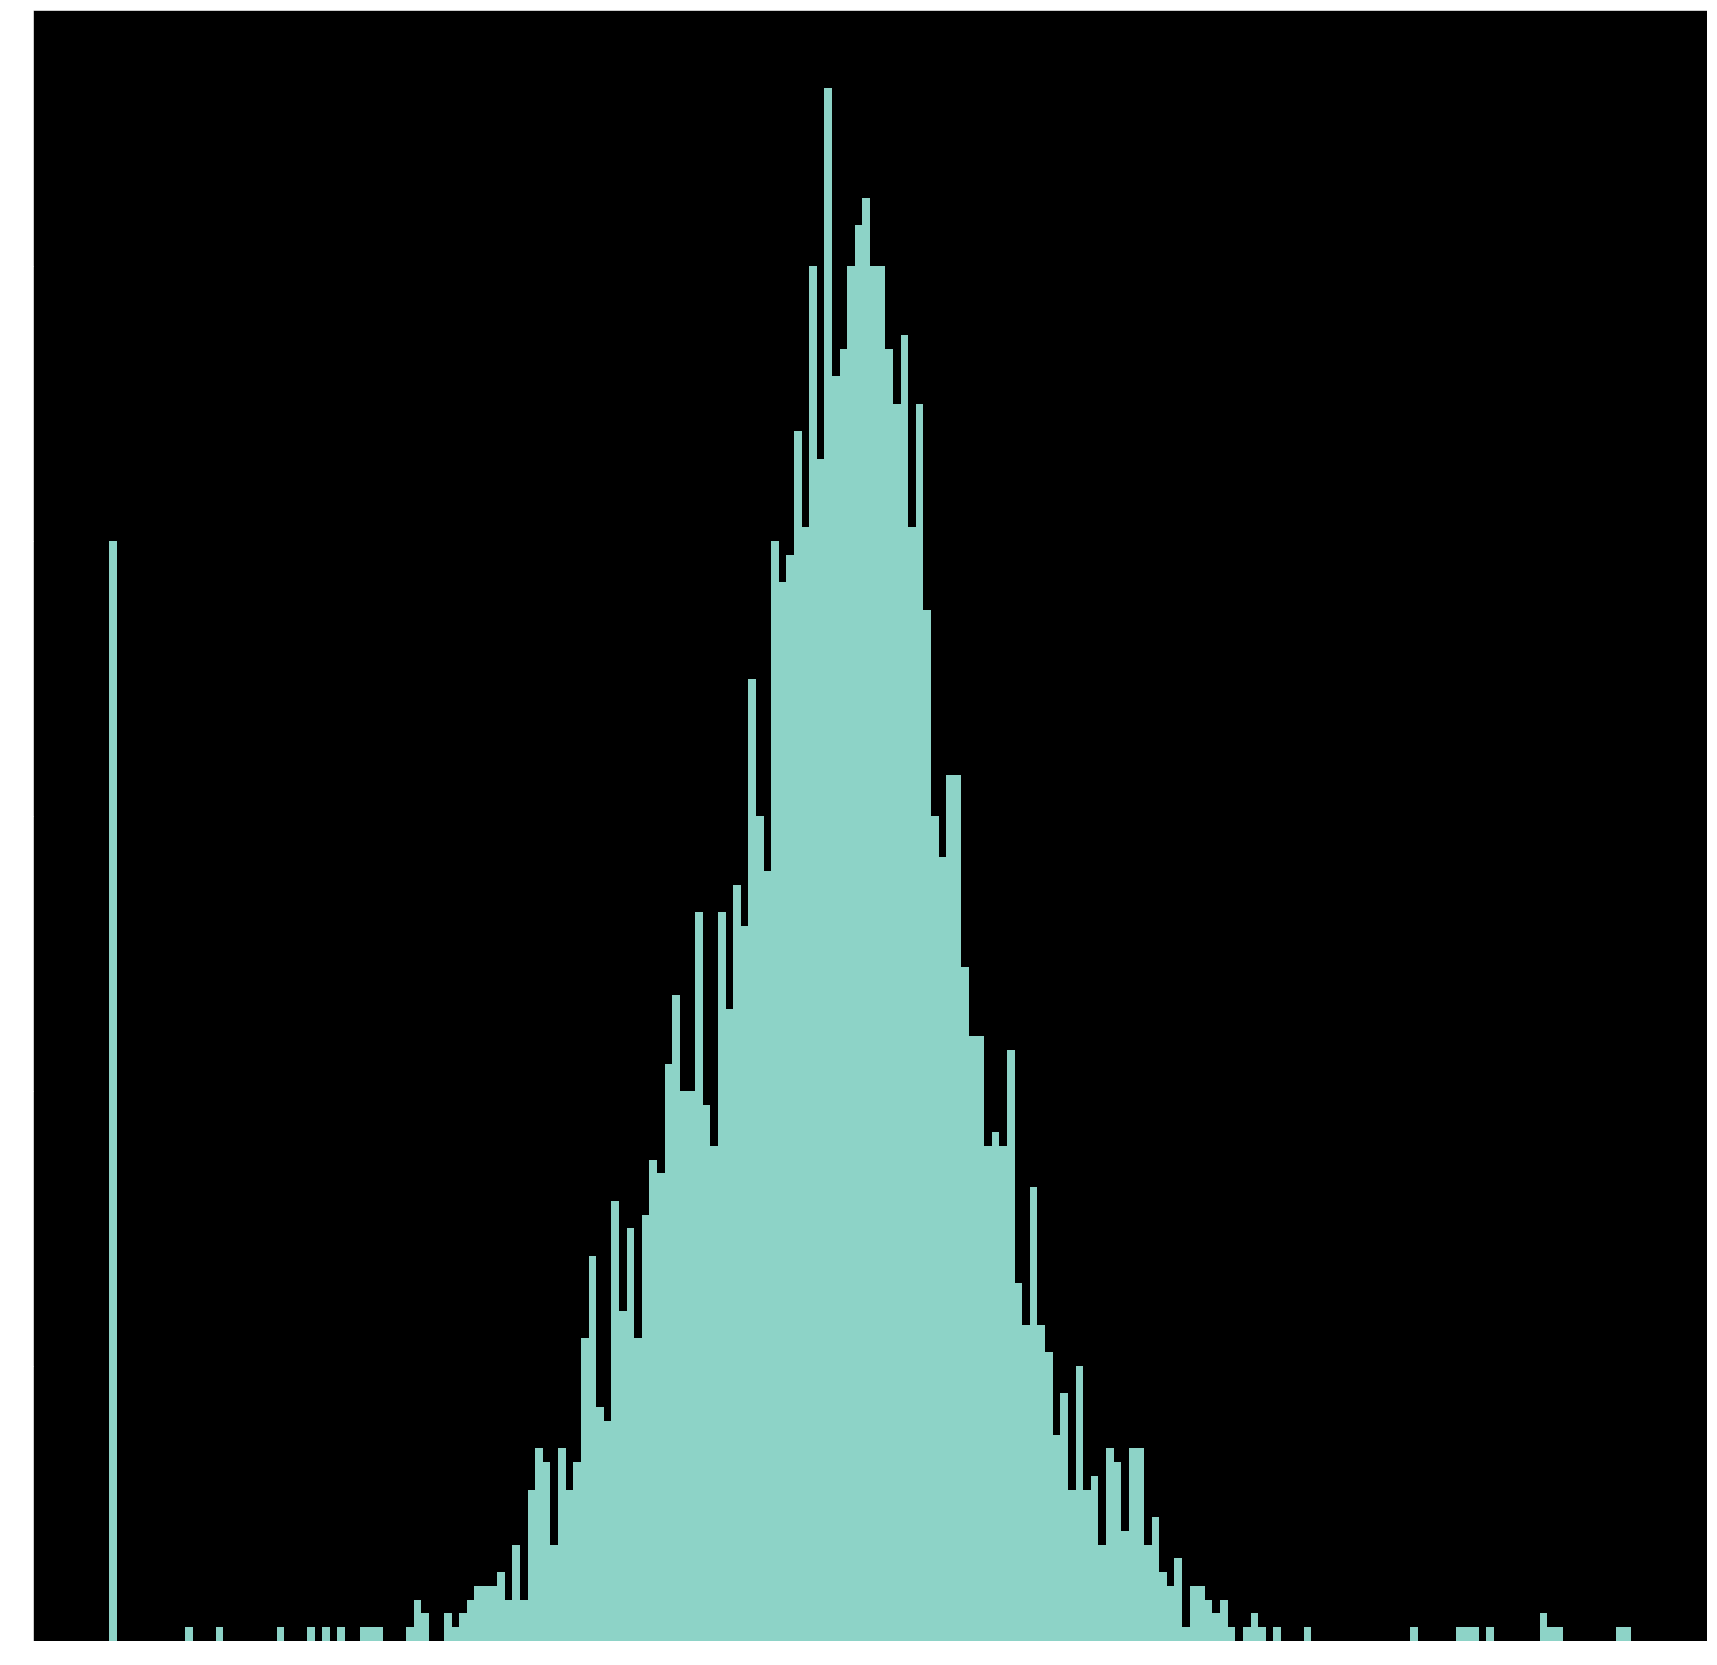

In [53]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(non_salt_regions_mean_brightness, bins=200)
plt.show()

In [54]:
#def compute_color_channel_mode(color_channel):
#    #return scipy.stats.mode(color_channel, axis=None)
#    return scipy.stats.mode(color_channel, axis=0)

def calculate_mode(sample):
    #print("calculate_mode, sample.shape:", sample.shape)
    #print(sample)
    flatten_sample = sample.flatten()
    #print("calculate_mode, flatten_sample.shape:", flatten_sample.shape)
    #print("calculate_mode, flatten_sample:\n", flatten_sample)
    counter = collections.Counter(sample.flatten())
    most_common = counter.most_common()
    if len(most_common) > 0:
        if len(most_common) == 1:
            return most_common[0]
        else:
            if most_common[0][0] == 0:
                return most_common[1]
            else:
                return most_common[0]
    else:
        return None
compute_color_channel_mode = calculate_mode

In [55]:
def collect_modes_and_frequencies(modes):
    modes_frequencies_dict = {}
    for color_channels_modes in modes:
        mode_value, frequency = color_channels_modes[0]
        if mode_value in modes_frequencies_dict:
            modes_frequencies_dict[mode_value] += frequency
        else:
            modes_frequencies_dict[mode_value] = frequency
    return modes_frequencies_dict

In [56]:
def compute_color_channels_modes(color_channels):
    #print("compute_color_channels_modes, len(color_channels): ", len(color_channels))
    #print("compute_color_channels_modes, color_channels:\n", color_channels)
    return [compute_color_channel_mode(color_channel) for color_channel in color_channels]

In [57]:
def compute_images_color_channels_modes(images_color_channels):
    return [
        compute_color_channels_modes(image_color_channels)\
        for image_color_channels in images_color_channels
    ]

In [58]:
def compare_pixel_color_channels_values(pixel):
    first_channel_value, second_channel_value, third_channel_value = pixel
    return (first_channel_value == second_channel_value) and (second_channel_value == third_channel_value)

In [59]:
def get_image_pixels(color_channels):
    return [
        (channel0value, channel1value, channel2value) for channel0value, channel1value, channel2value
           in zip(color_channels[0], color_channels[1], color_channels[2])
    ]

In [60]:
def get_image_pixels(image):
    color_channel0 = image[:, :, 0].ravel()
    color_channel1 = image[:, :, 1].ravel()
    color_channel2 = image[:, :, 1].ravel()
    return [(x, y, z) for x, y, z in zip(color_channel0, color_channel1, color_channel2)]    

In [61]:
def compare_color_channels_by_pixels(image):
    image_pixels = get_image_pixels(image)
    return [compare_pixel_color_channels_values(pixel) for pixel in image_pixels]

In [62]:
def compare_images_color_channels(images):
    return [compare_color_channels_by_pixels(image) for image in images]

In [63]:
images_color_channels = [get_image_color_channels(image_description[1]) for image_description in images_descriptions]

In [64]:
images_masks = [image_description[2] for image_description in images_descriptions]

In [65]:
masked_images_color_channels = [
    apply_mask_to_color_channels(image_color_channels, mask) for image_color_channels, mask in zip(
        images_color_channels,
        images_masks
    )
]

In [66]:
#masked_images_color_channels_modes = [
#    compute_color_channels_modes(masked_image_color_channel)\
#   for masked_image_color_channel in masked_images_color_channels
#]
masked_images_color_channels_modes = compute_images_color_channels_modes(
    masked_images_color_channels
)

In [67]:
masked_images_color_channels_modes[1]

[(0.68235296, 36), (0.68235296, 36), (0.68235296, 36)]

In [68]:
print(masked_images_color_channels_modes)

[[(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.68235296, 36), (0.68235296, 36), (0.68235296, 36)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.4745098, 6), (0.4745098, 6), (0.4745098, 6)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.25490198, 1843), (0.25490198, 1843), (0.25490198, 1843)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.6392157, 183), (0.6392157, 183), (0.6392157, 183)], [(0.34509805, 312), (0.34509805, 312), (0.34509805, 312)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.34901962, 452), (0.34901962, 452), (0.34901962, 452)], [(0.4392157, 4), (0.4392157, 4), (0.4392157, 4)], [(0.4745098, 1790), (0.4745098, 1790), (0.4745098, 1790)], [(0.25490198, 1358), (0.25490198, 1358), (0.25490198, 1358)], [(0.44313726, 17), (0.44313726, 17), (0.44313726, 17)], [(0.0, 10201), (0.0, 10201), (0.0, 10201)], [(0.5529412, 42), (0.5529412, 42), (0.5529412, 42)], [(0.5137255, 85), (0.5137

In [69]:
images = [
    image_description[1] for image_description in images_descriptions
]

In [70]:
#image0_color_channels = images_color_channels[0]

In [71]:
#print(image0_color_channels)

In [72]:
color_channels_comparation_results = compare_images_color_channels(images)

In [73]:
#print(color_channels_comparation_results[:10])

In [74]:
masked_images_color_channels_modes_collected = collect_modes_and_frequencies(
    masked_images_color_channels_modes
)

In [75]:
modes_values = masked_images_color_channels_modes_collected.keys()
modes_frequencies = masked_images_color_channels_modes_collected.values()

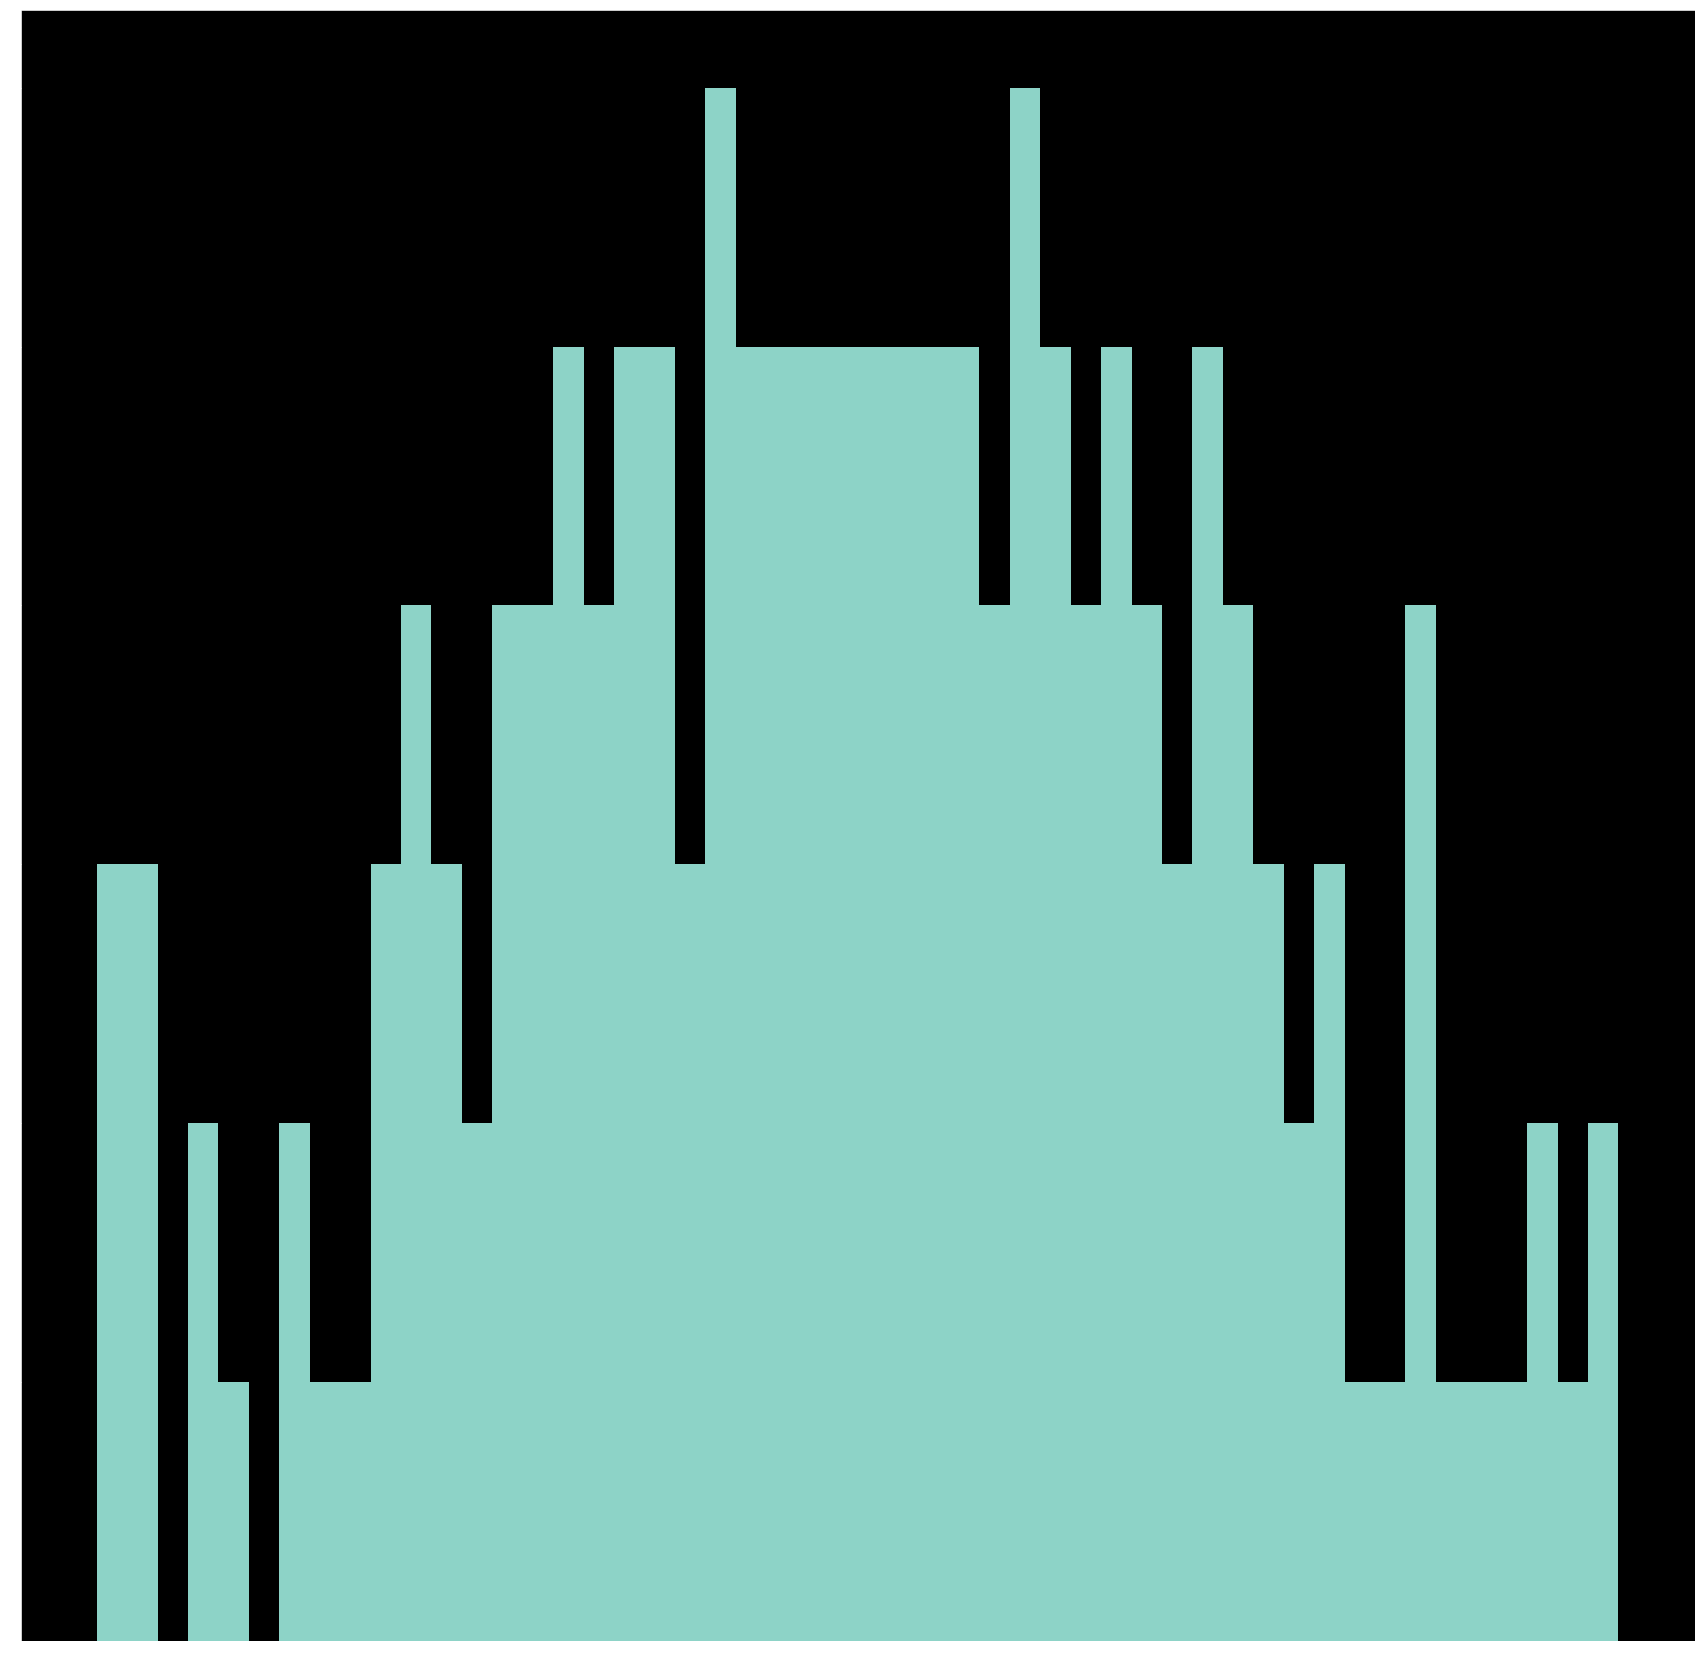

In [91]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(modes_values, bins=50)
plt.show()

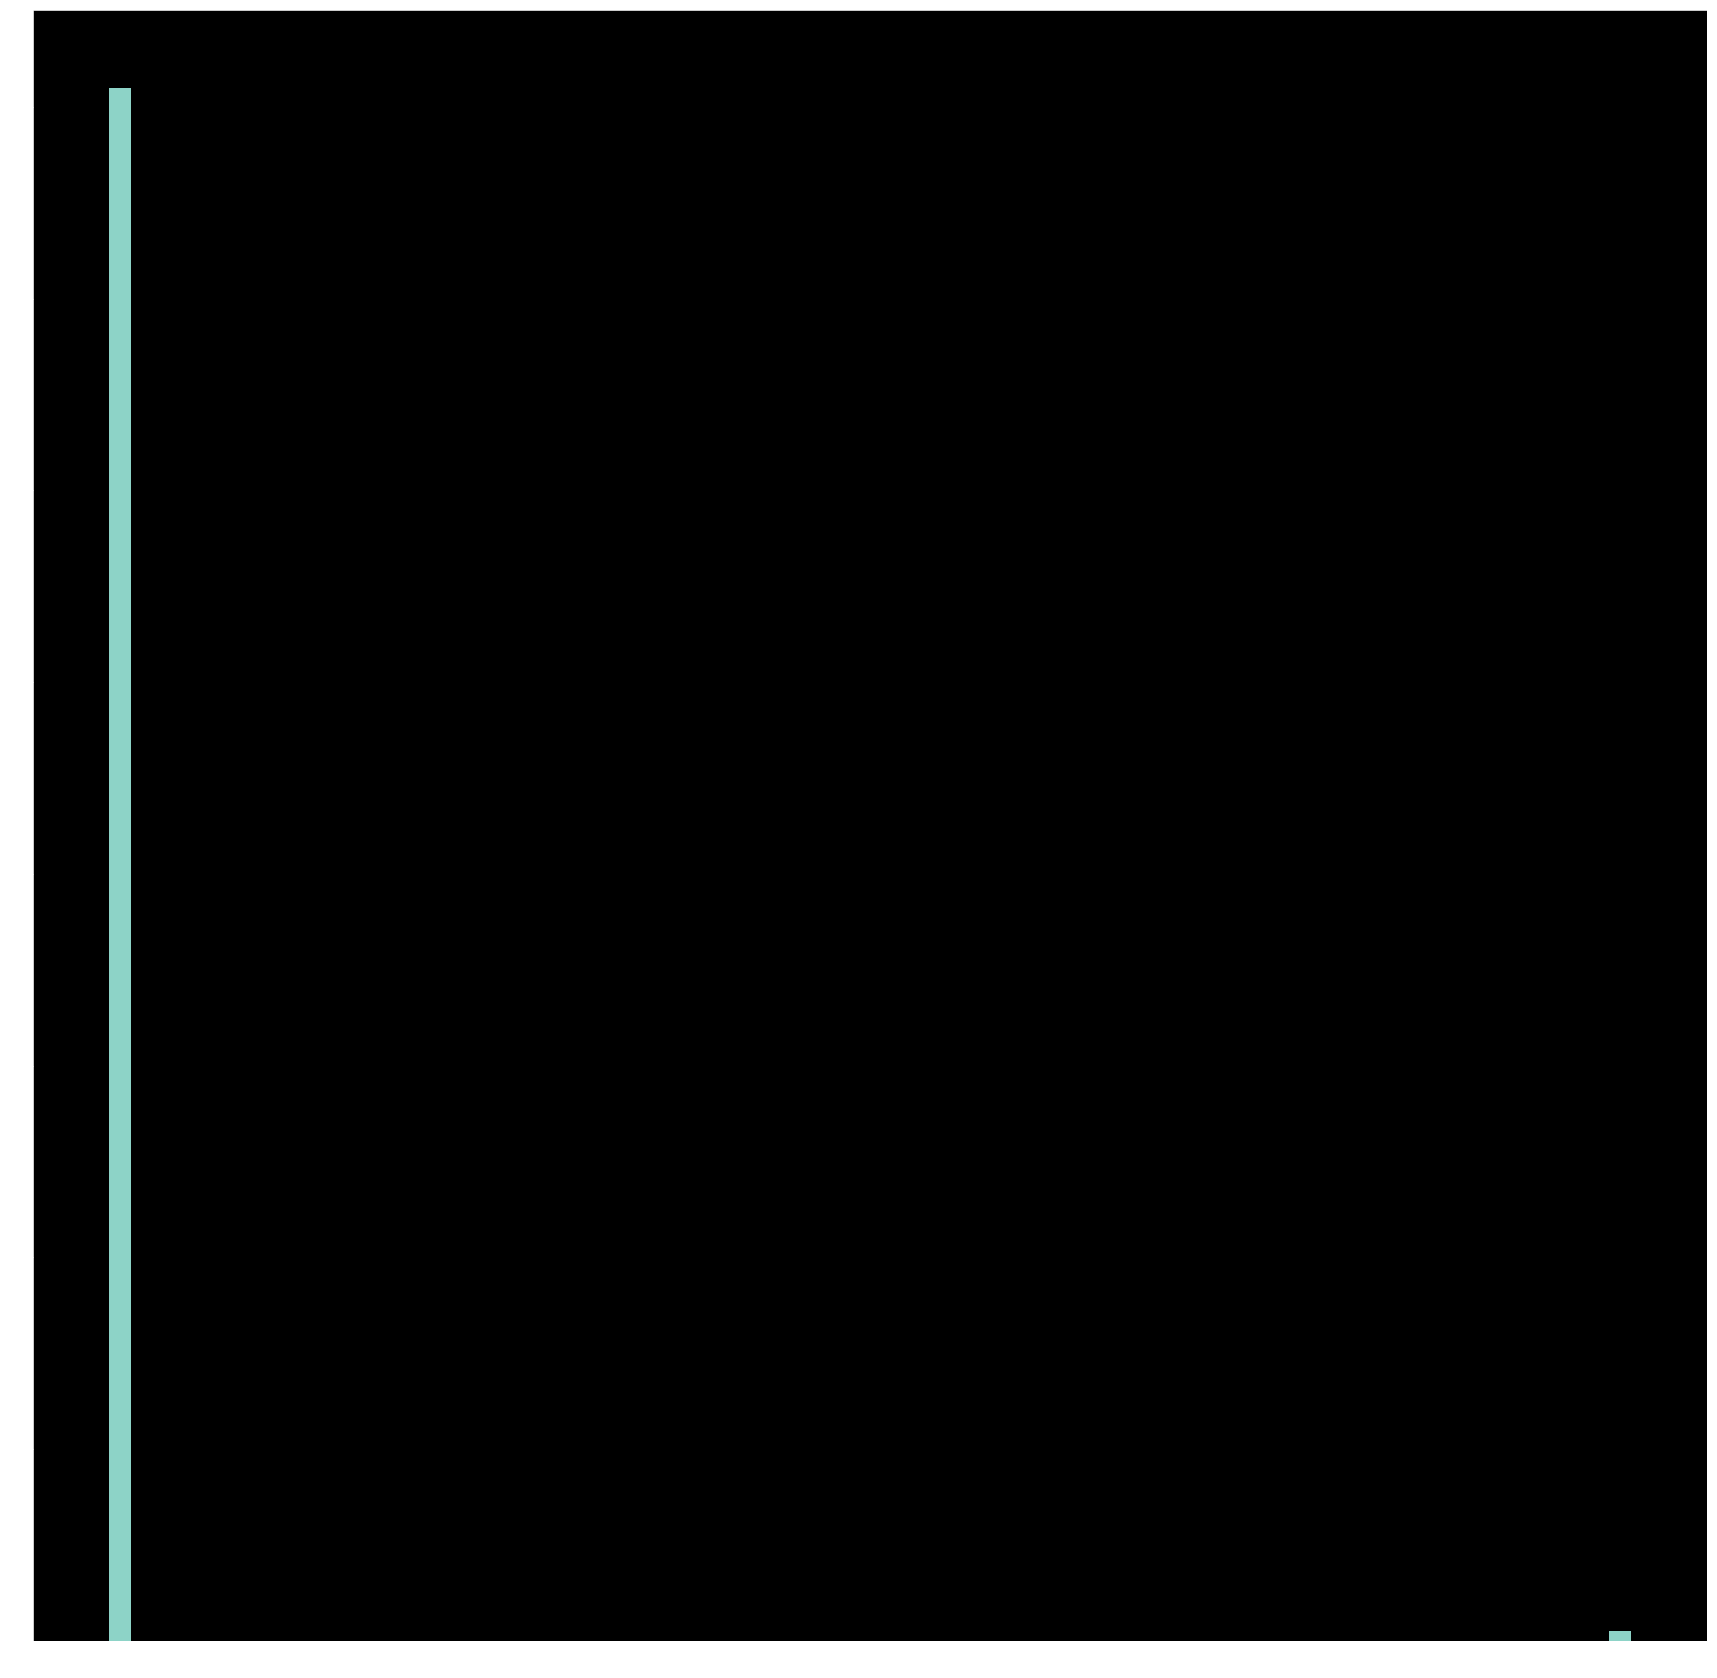

In [97]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(modes_frequencies, bins=70)
plt.show()

In [78]:
print(len(modes_frequencies))
print(len(modes_values))

163
163


In [79]:
sorted_modes_values = sorted(modes_values)
sorted_modes_frequencies = []
for mode_value in sorted_modes_values:
    sorted_modes_frequencies.append(masked_images_color_channels_modes_collected[mode_value])

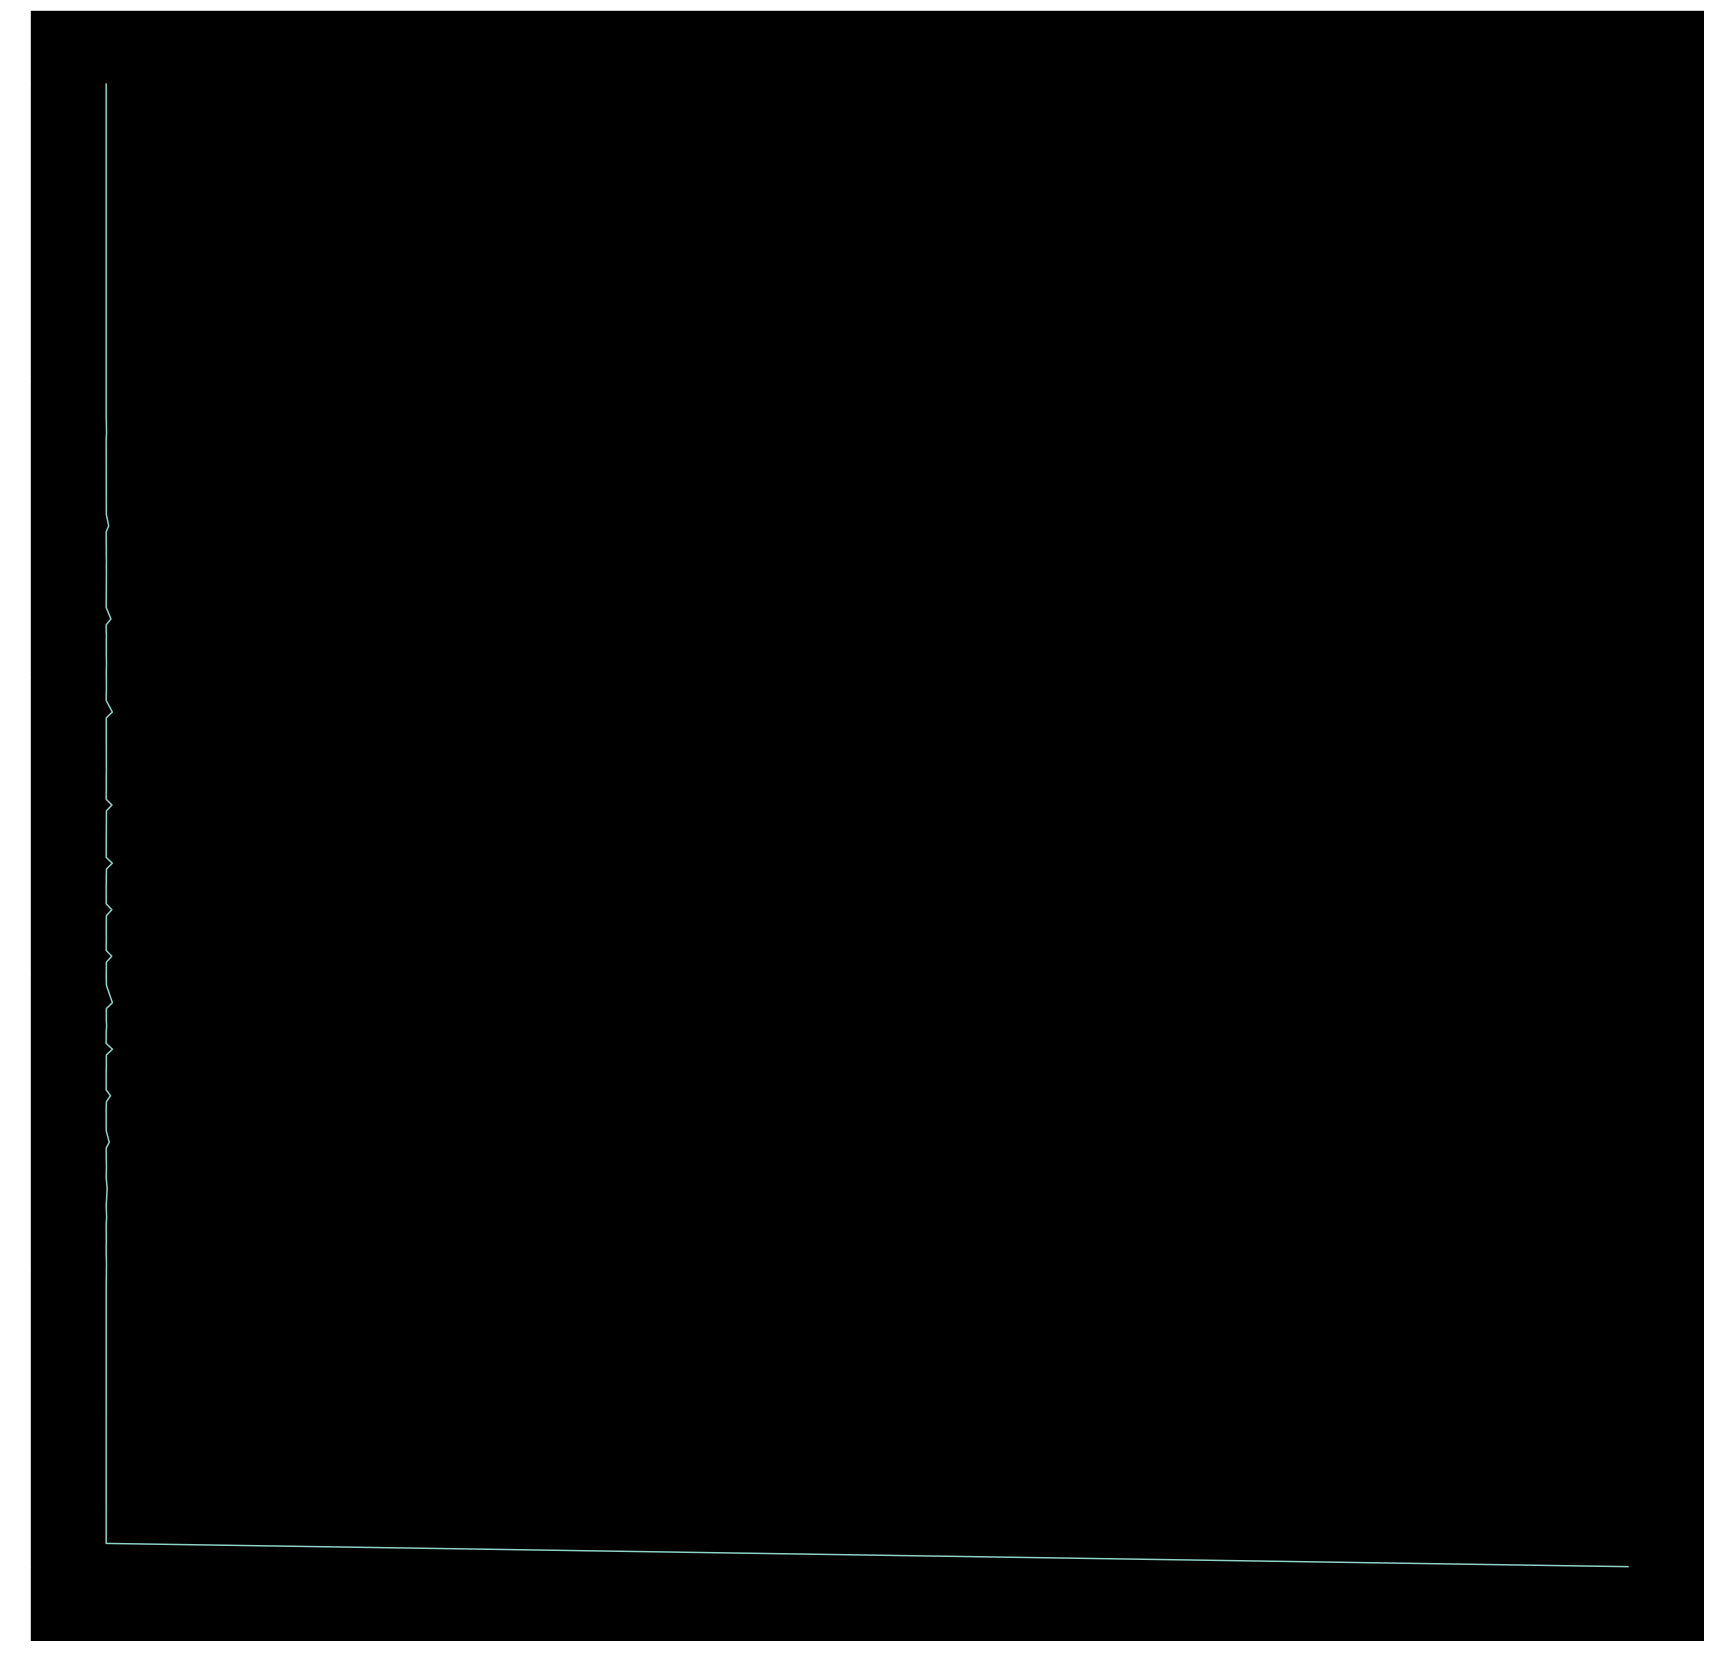

In [80]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(sorted_modes_frequencies, sorted_modes_values)
plt.show()

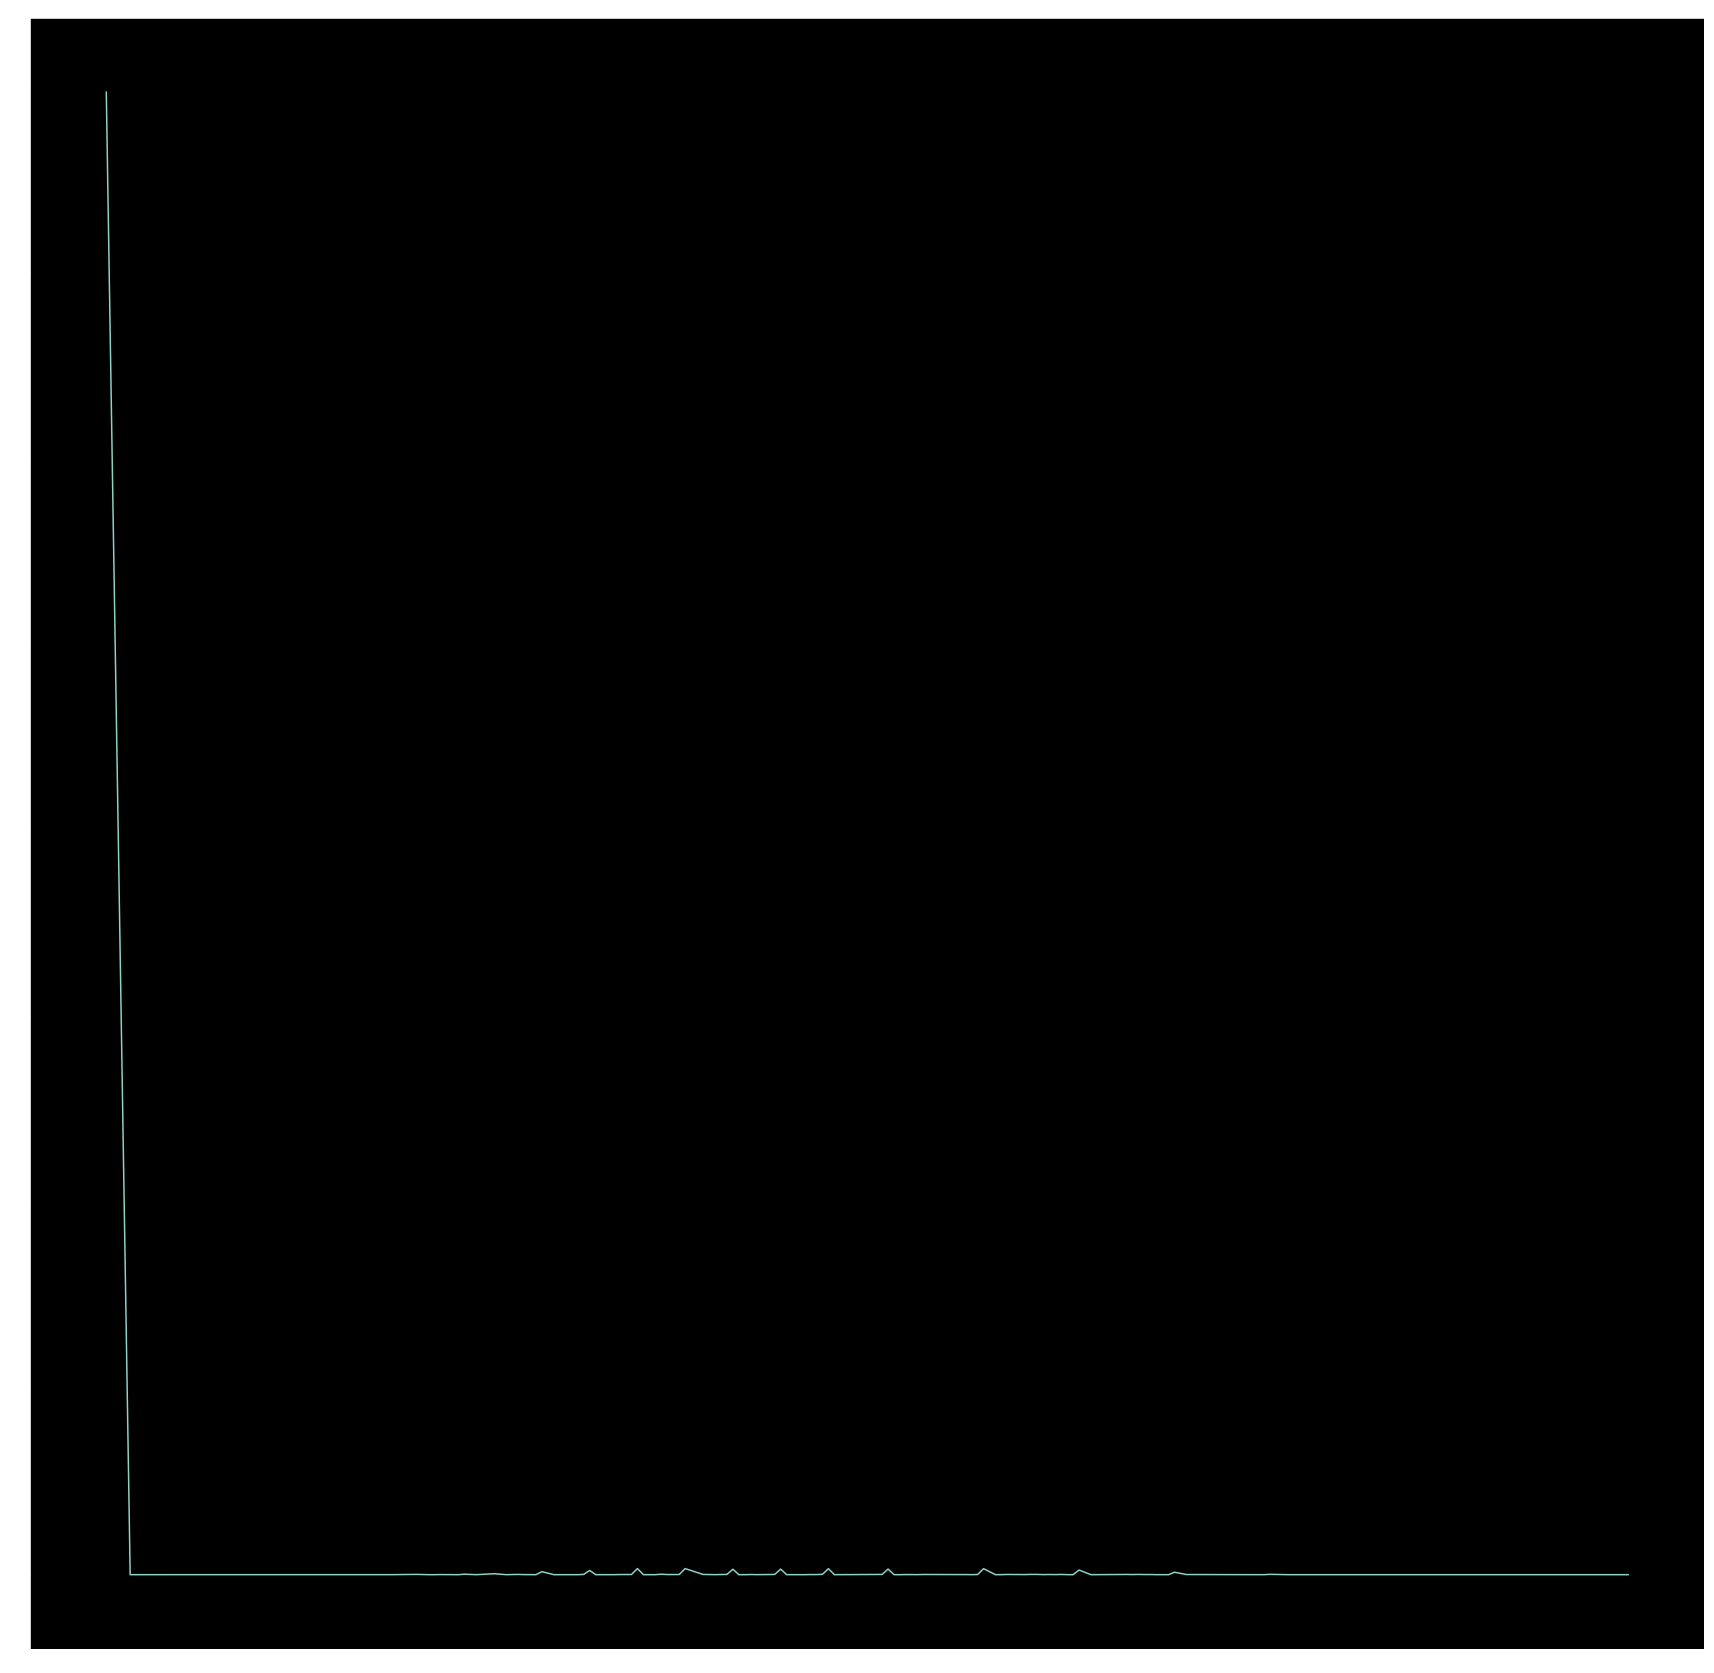

In [81]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(sorted_modes_values, sorted_modes_frequencies)
plt.show()

In [82]:
negative_masked_images_color_channels = [
    apply_negative_mask_to_color_channels(image_color_channels, mask) for image_color_channels, mask in zip(
        images_color_channels,
        images_masks
    )
]

In [83]:
negative_masked_images_color_channels_modes = compute_images_color_channels_modes(
    negative_masked_images_color_channels
)

In [84]:
negative_masked_images_color_channels_modes_collected = collect_modes_and_frequencies(
    negative_masked_images_color_channels_modes
)

In [85]:
negative_modes_values = negative_masked_images_color_channels_modes_collected.keys()
negative_modes_frequencies = negative_masked_images_color_channels_modes_collected.values()

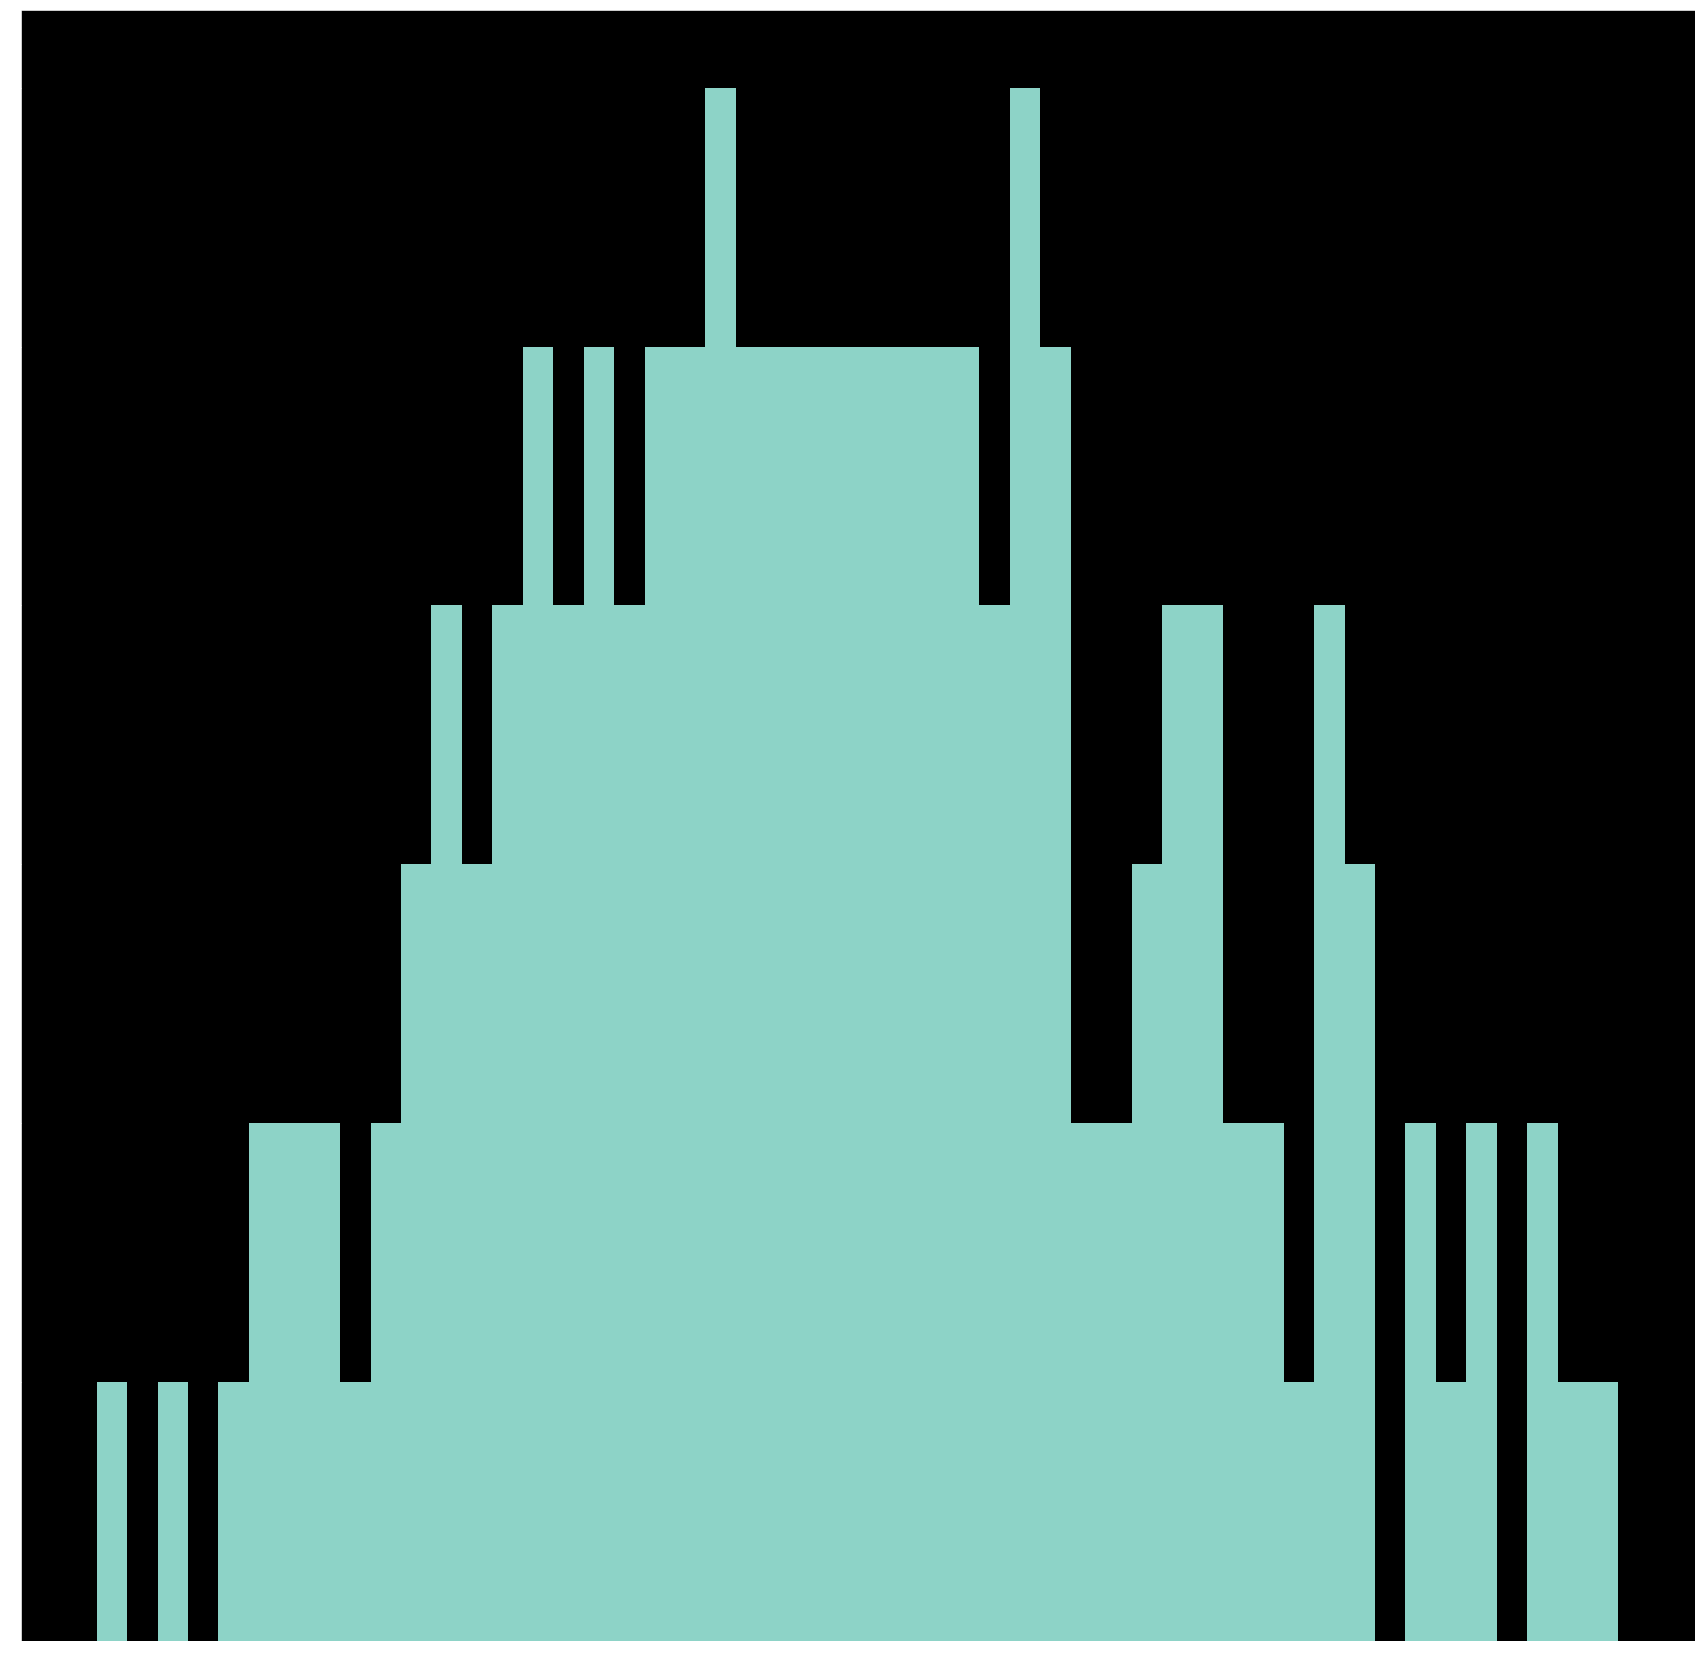

In [92]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(negative_modes_values, bins=50)
plt.show()

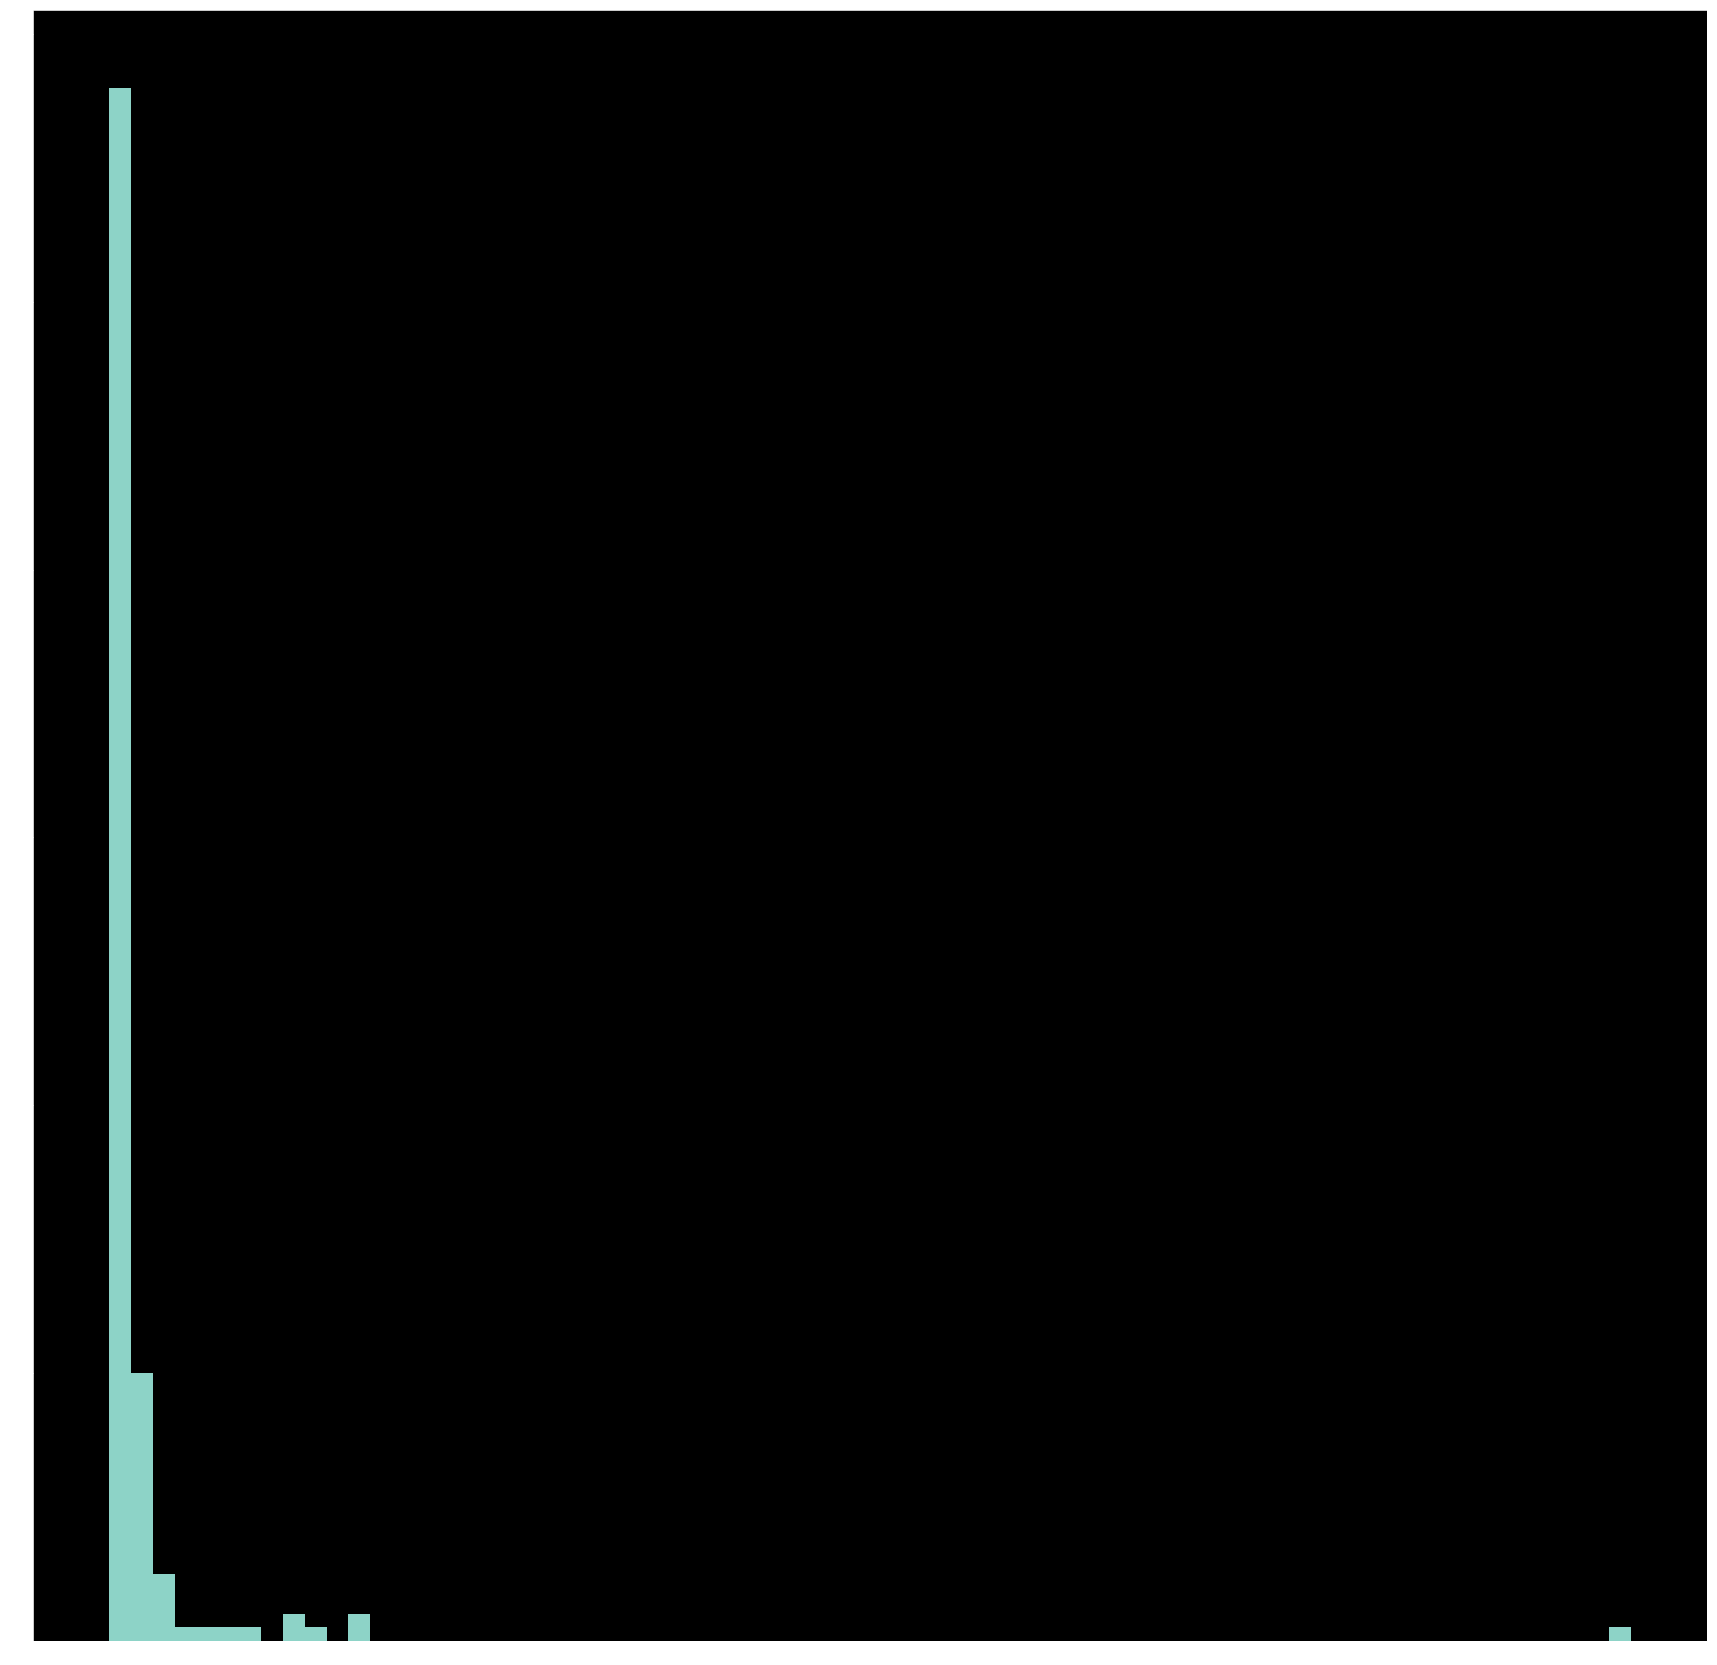

In [96]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(negative_modes_frequencies, bins=70)
plt.show()

In [87]:
sorted_negative_modes_values = sorted(negative_modes_values)
sorted_negative_modes_frequencies = []
for negative_mode_value in sorted_negative_modes_values:
    sorted_negative_modes_frequencies.append(negative_masked_images_color_channels_modes_collected[negative_mode_value])

In [93]:
print(len(negative_modes_frequencies))
print(len(negative_modes_values))

151
151


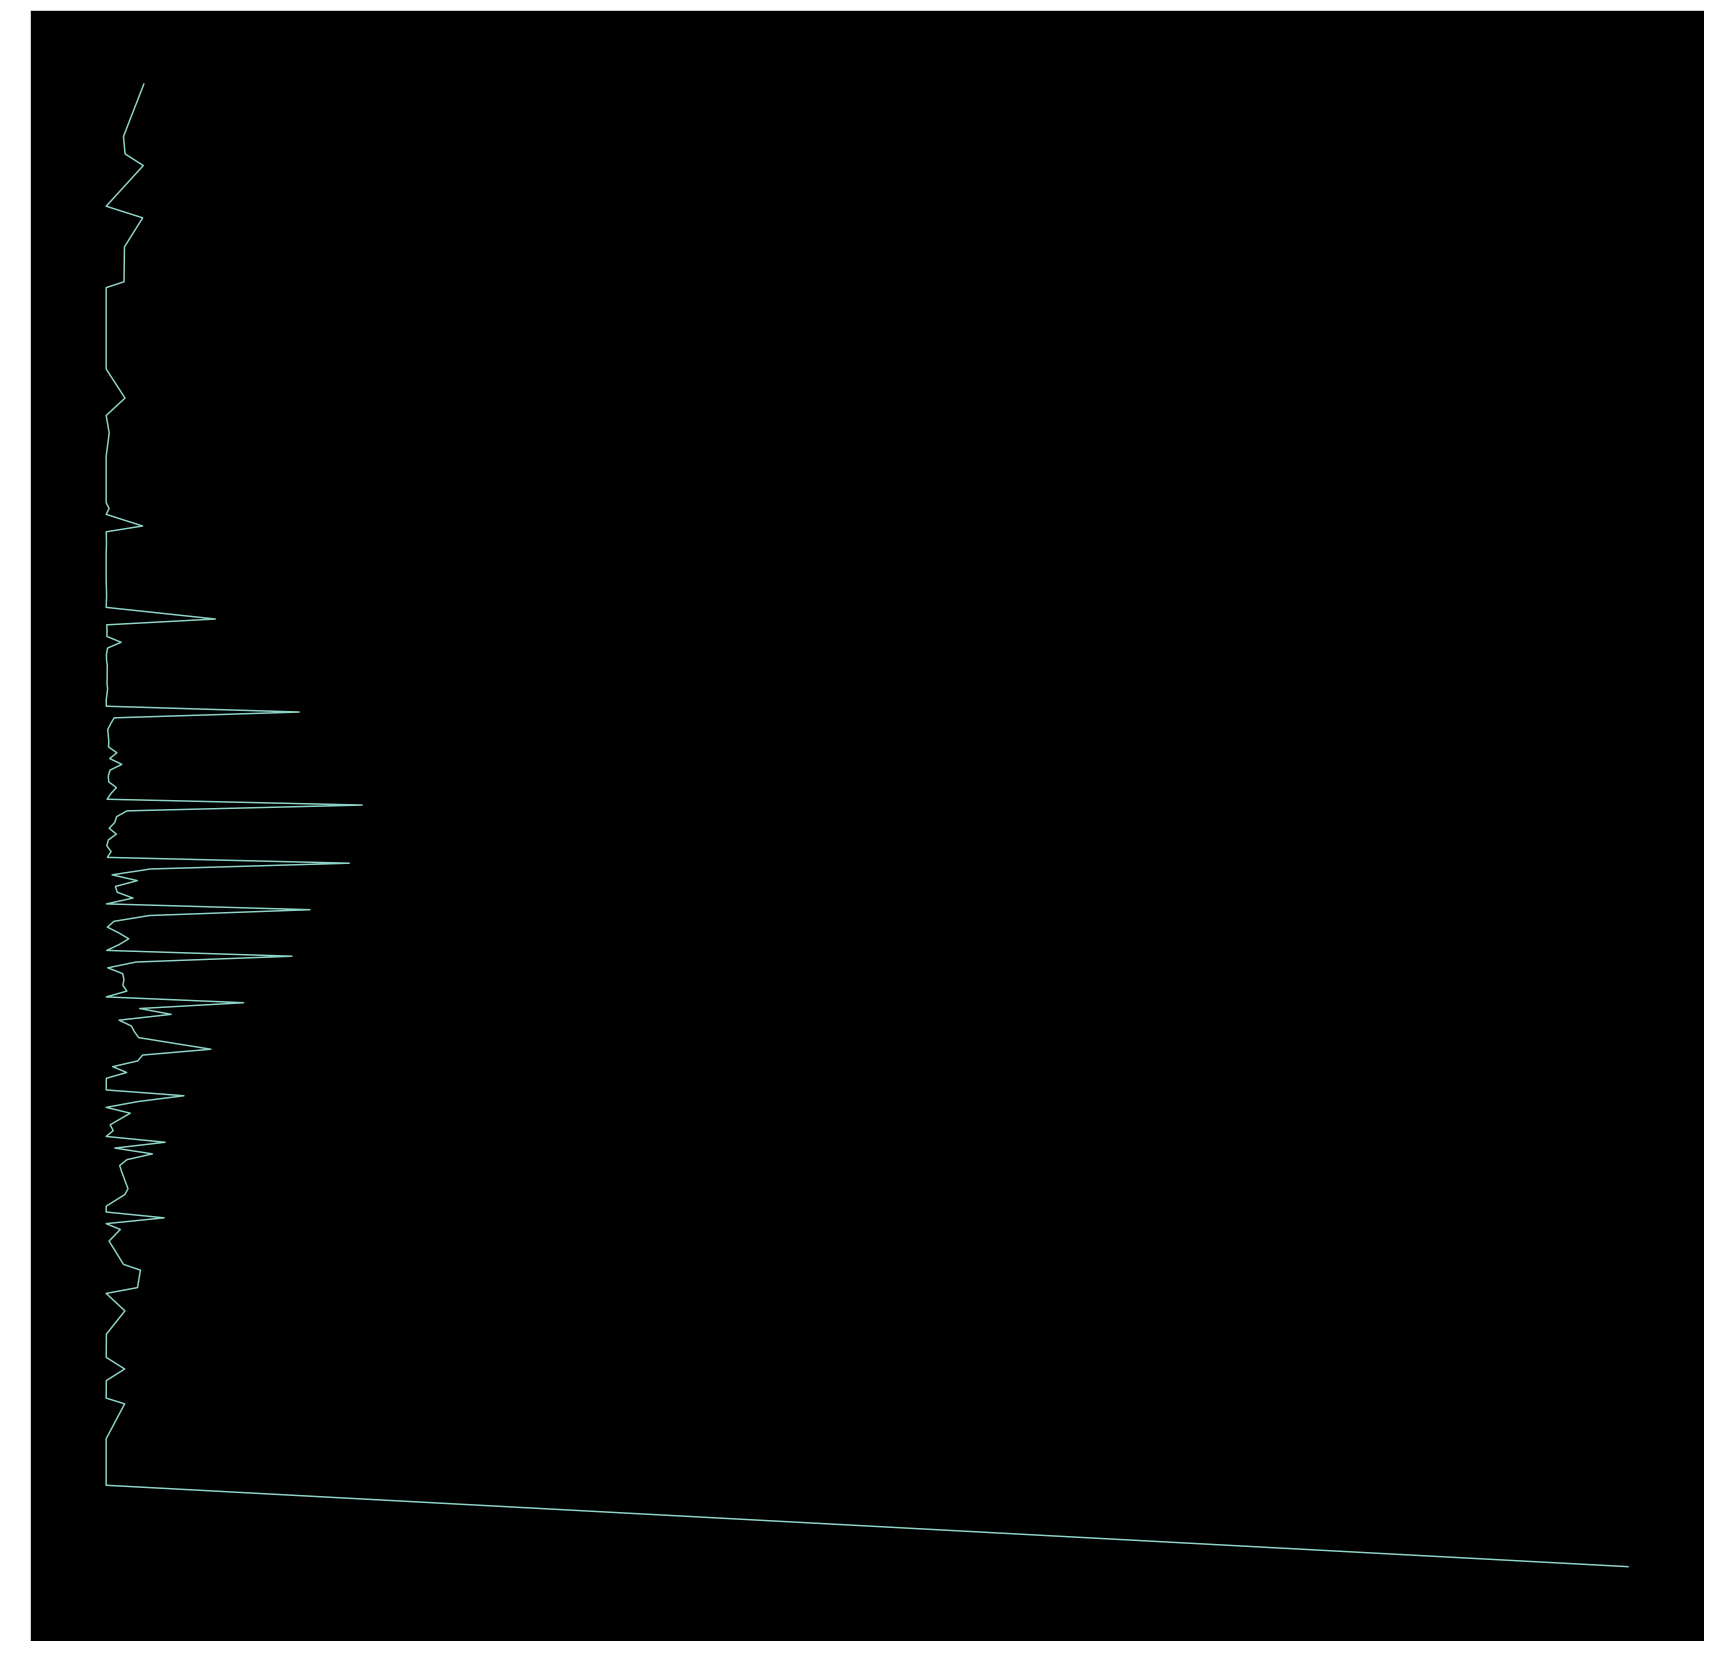

In [94]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(sorted_negative_modes_frequencies, sorted_negative_modes_values)
plt.show()

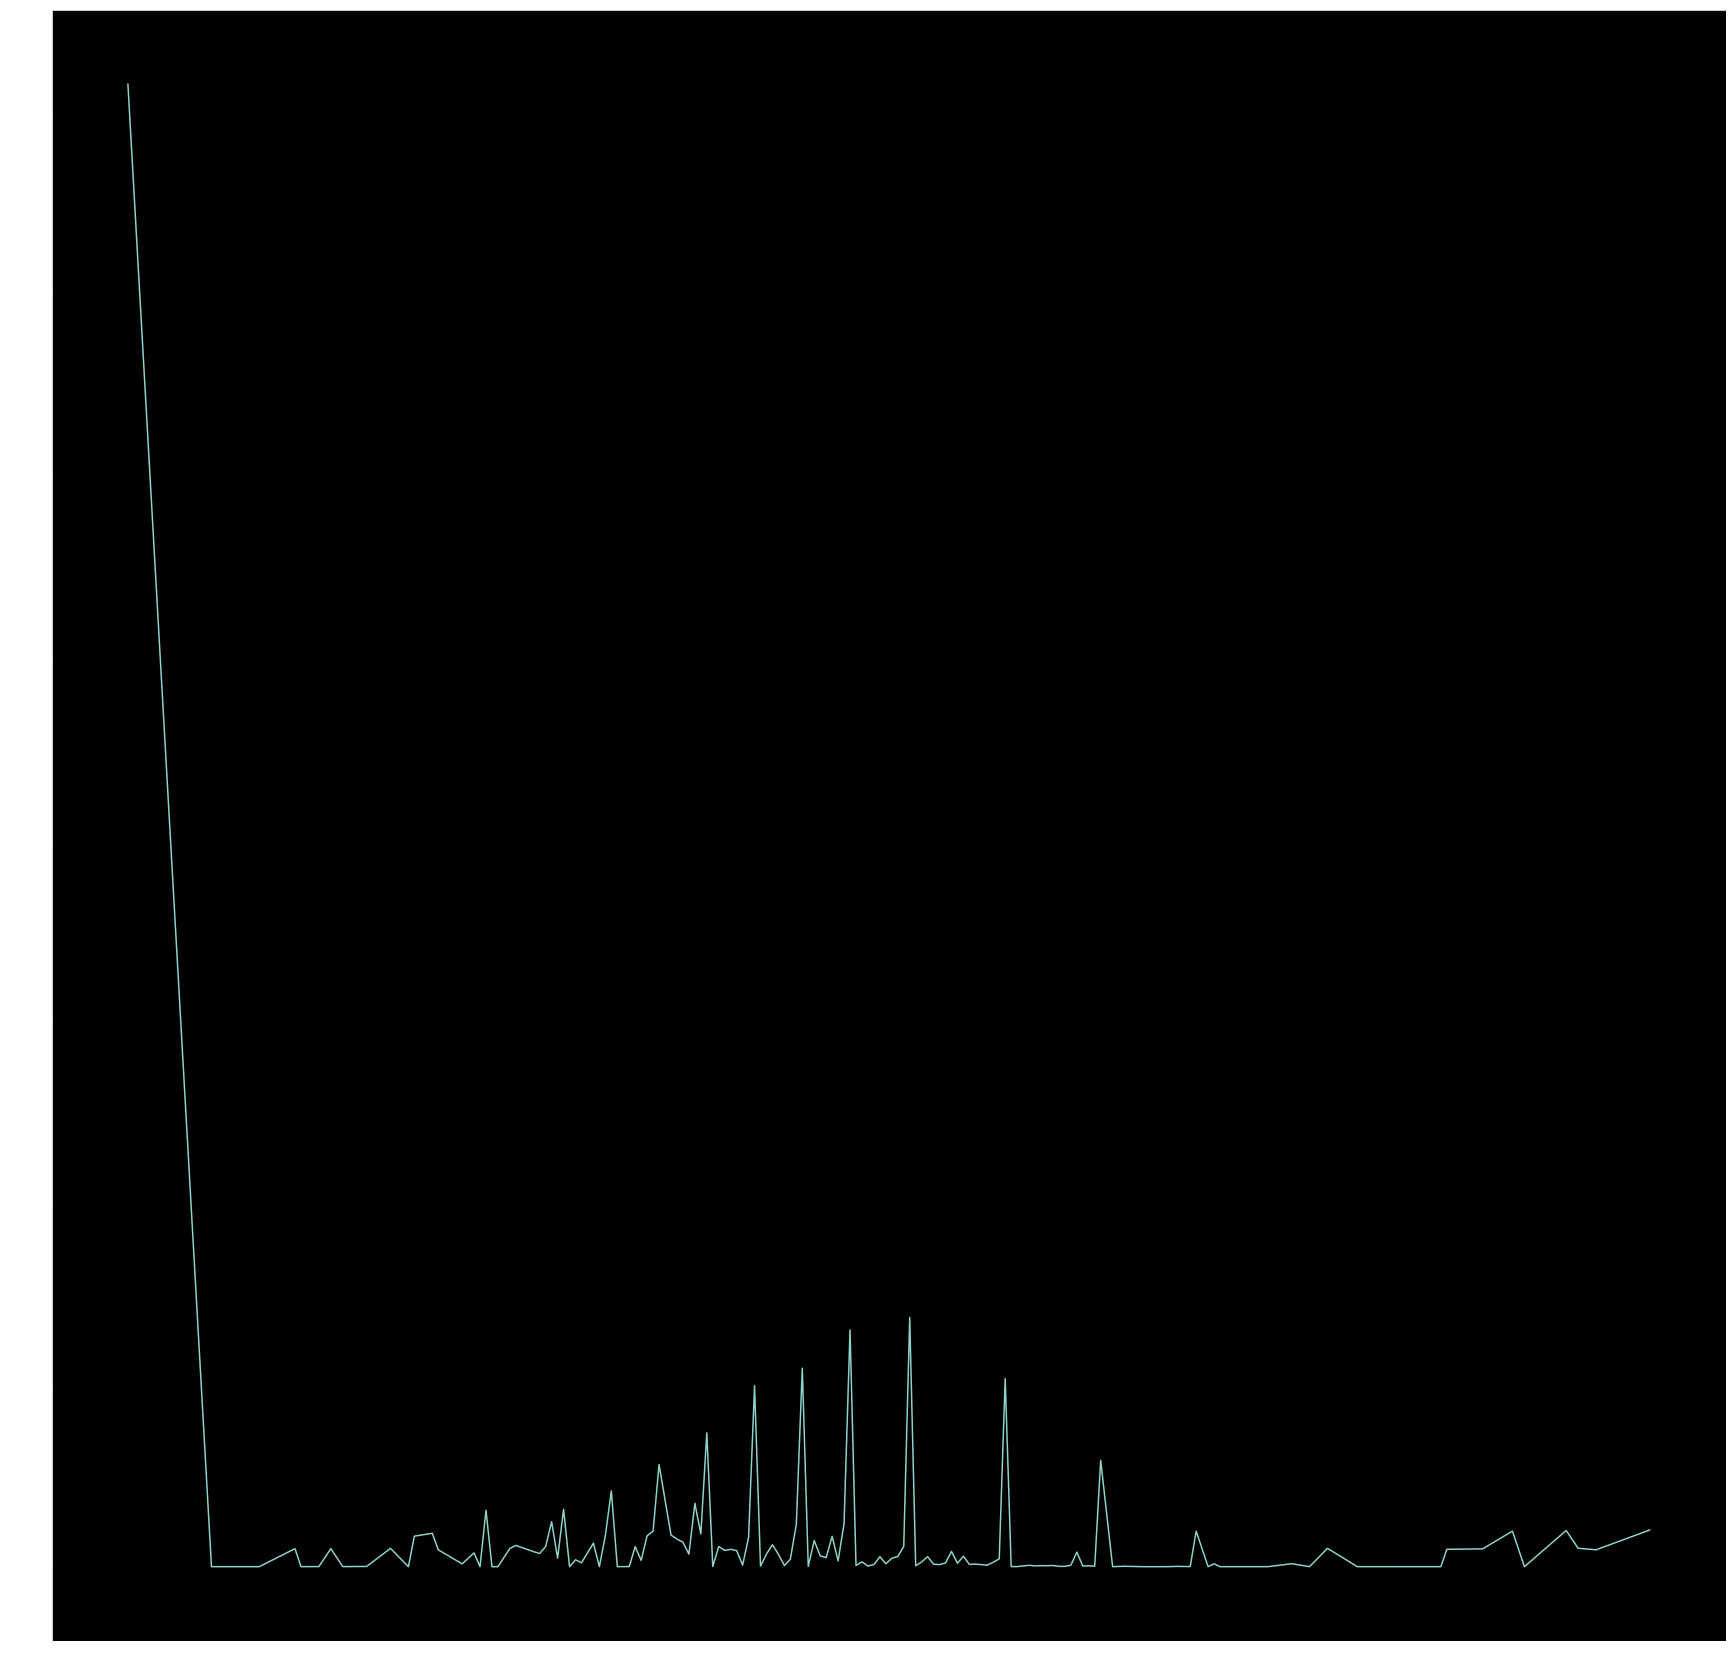

In [95]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(sorted_negative_modes_values, sorted_negative_modes_frequencies)
plt.show()

In [98]:
full_images_color_channels_modes = compute_images_color_channels_modes(
    images_color_channels
)

In [99]:
full_images_color_channels_modes_collected = collect_modes_and_frequencies(
    full_images_color_channels_modes
)

In [100]:
full_images_modes_values = full_images_color_channels_modes_collected.keys()
full_images_modes_frequencies = full_images_color_channels_modes_collected.values()

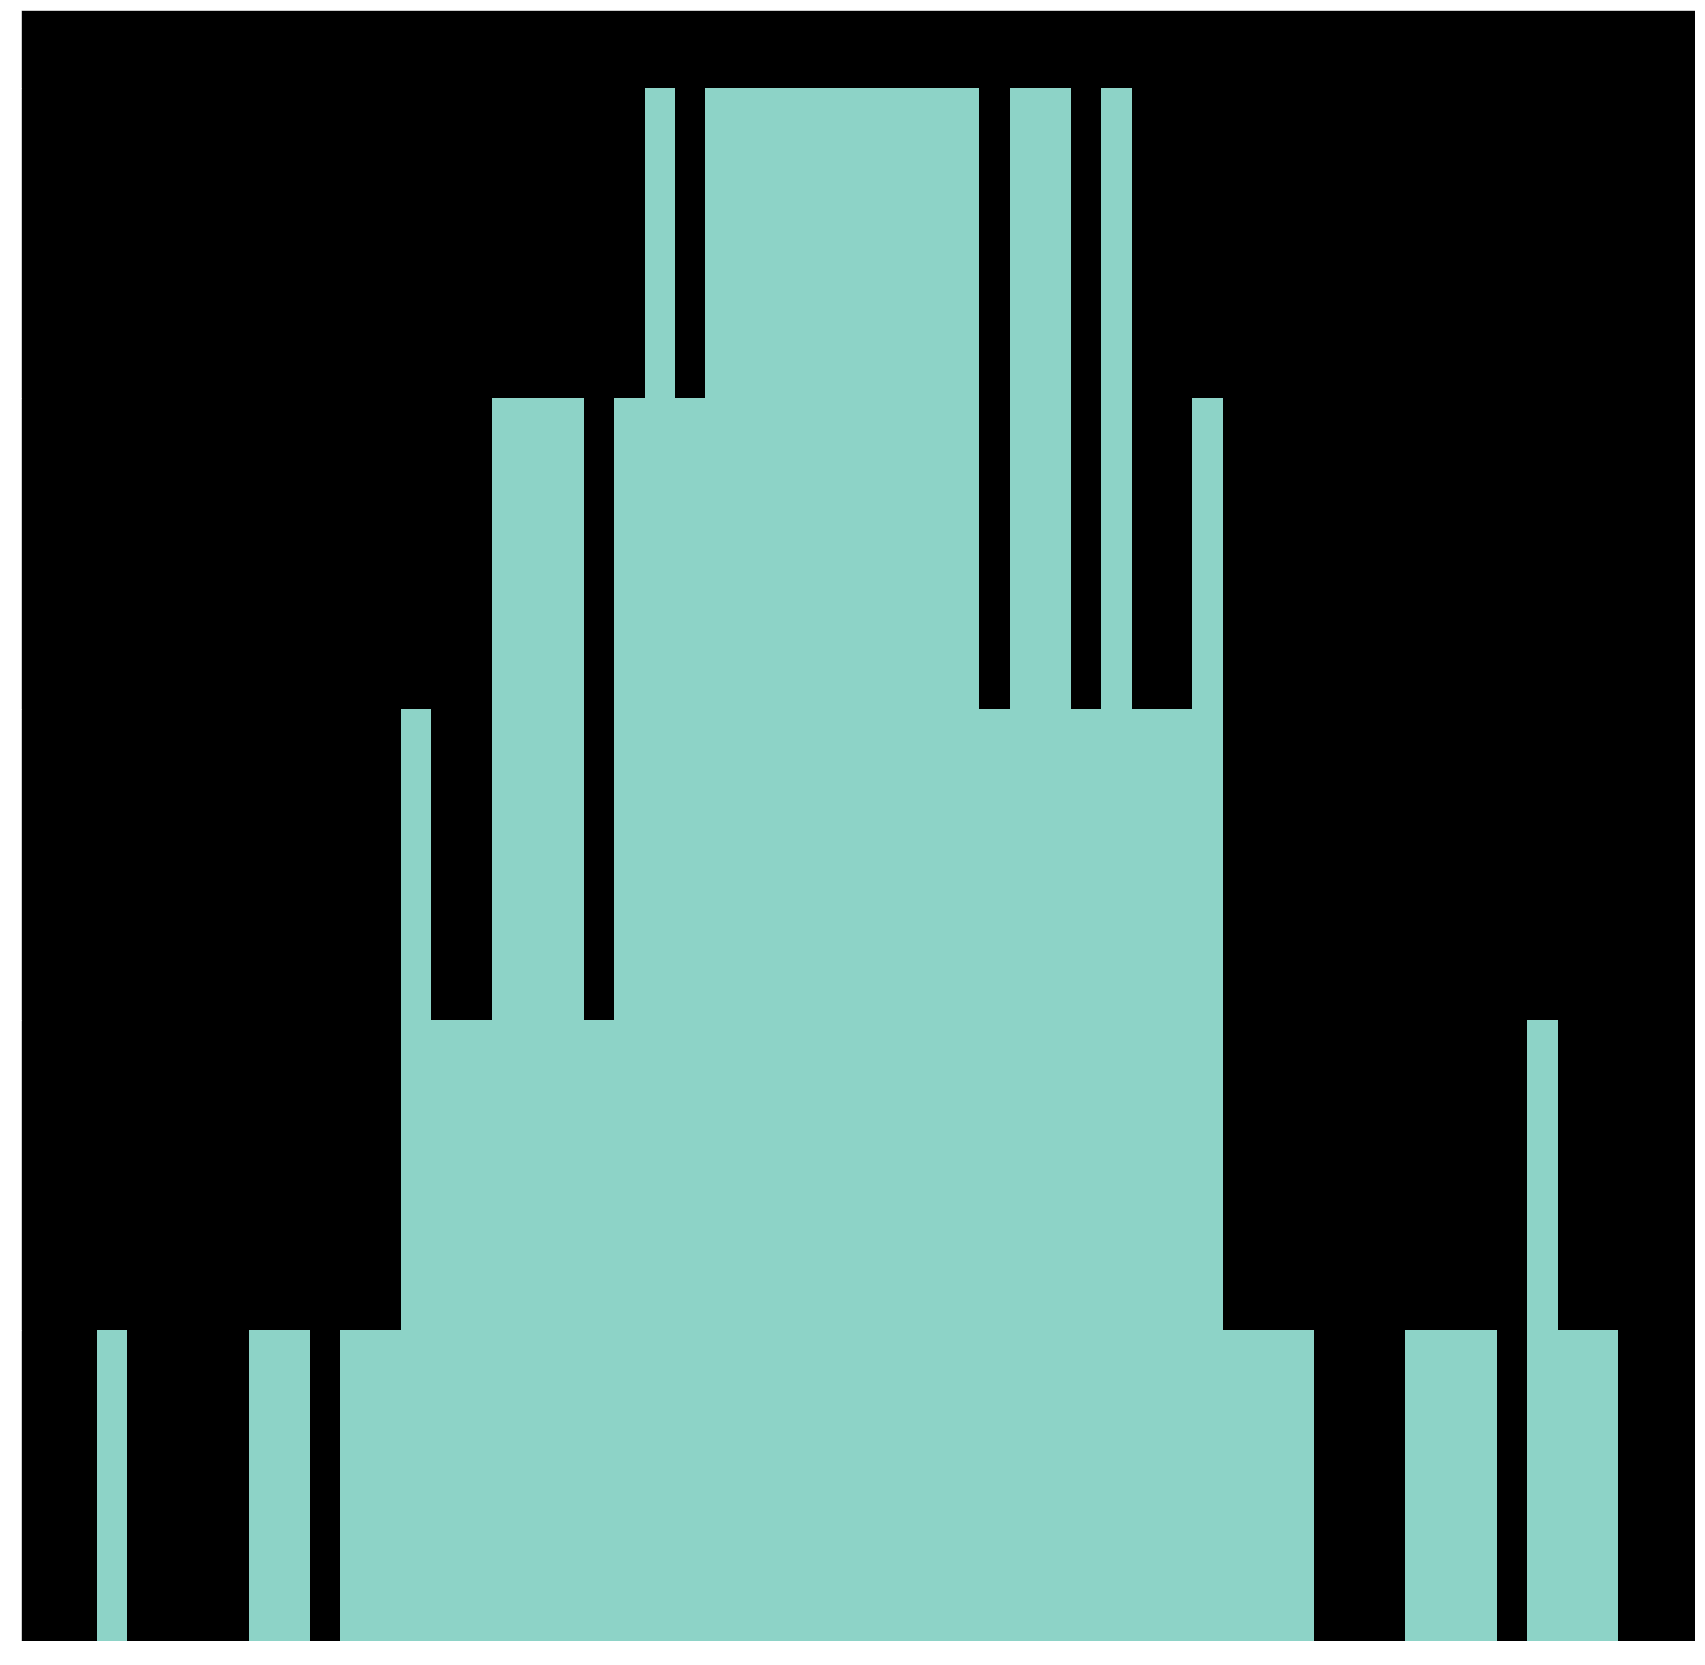

In [101]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(full_images_modes_values, bins=50)
plt.show()

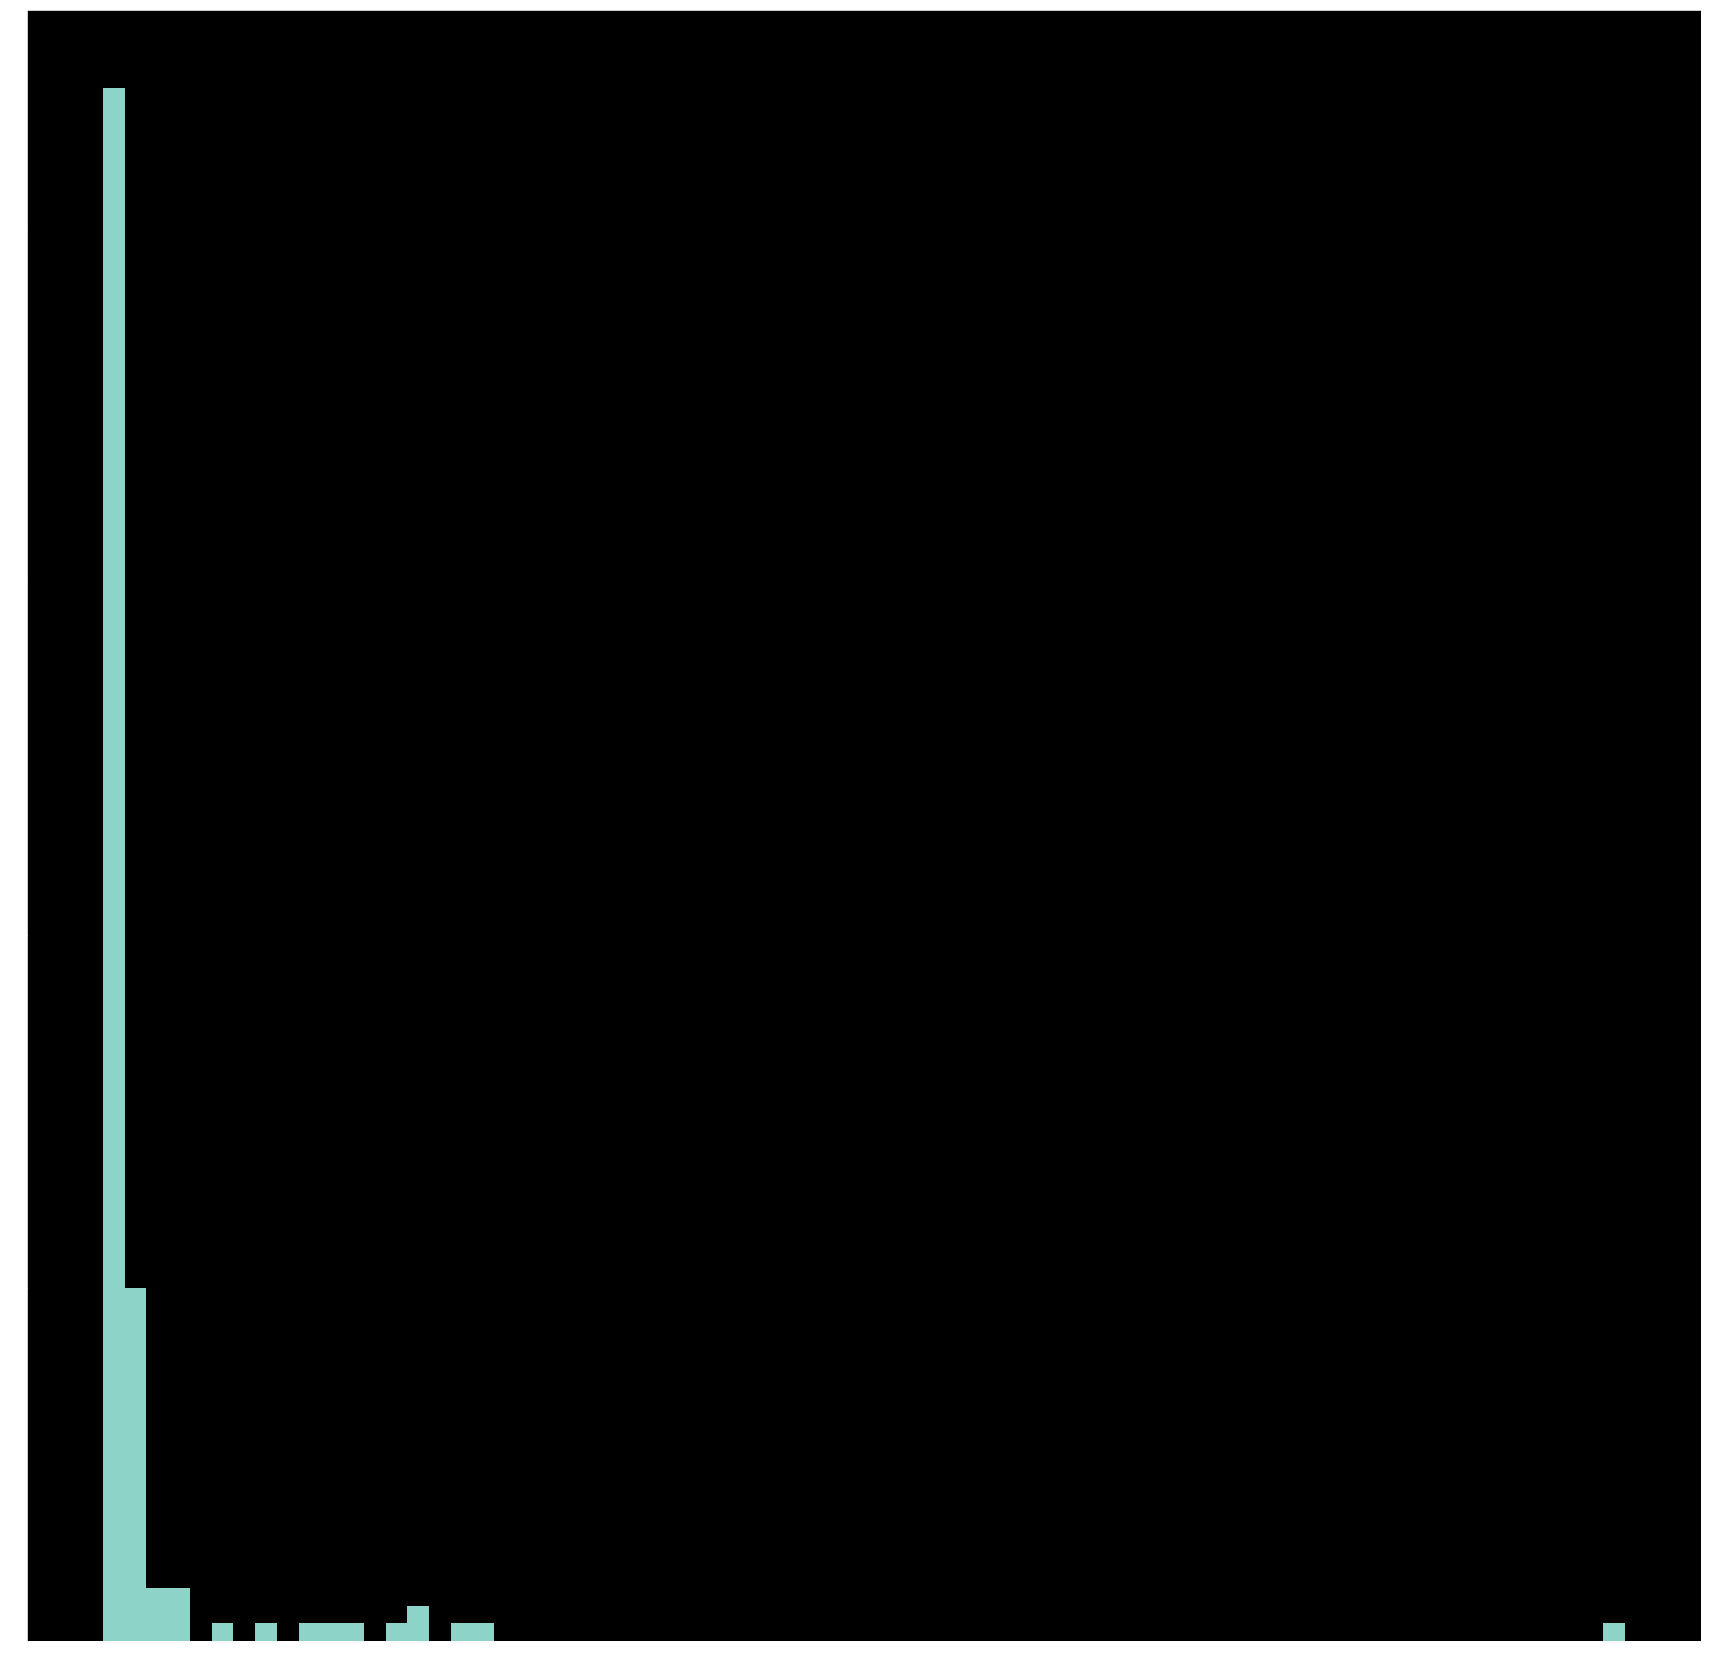

In [102]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(full_images_modes_frequencies, bins=70)
plt.show()

In [103]:
print(len(full_images_modes_values))
print(len(full_images_modes_frequencies))

125
125


In [104]:
sorted_full_images_modes_values = sorted(full_images_modes_values)
sorted_full_images_modes_frequencies = []
for full_image_mode_value in sorted_full_images_modes_values:
    sorted_full_images_modes_frequencies.append(full_images_color_channels_modes_collected[full_image_mode_value])

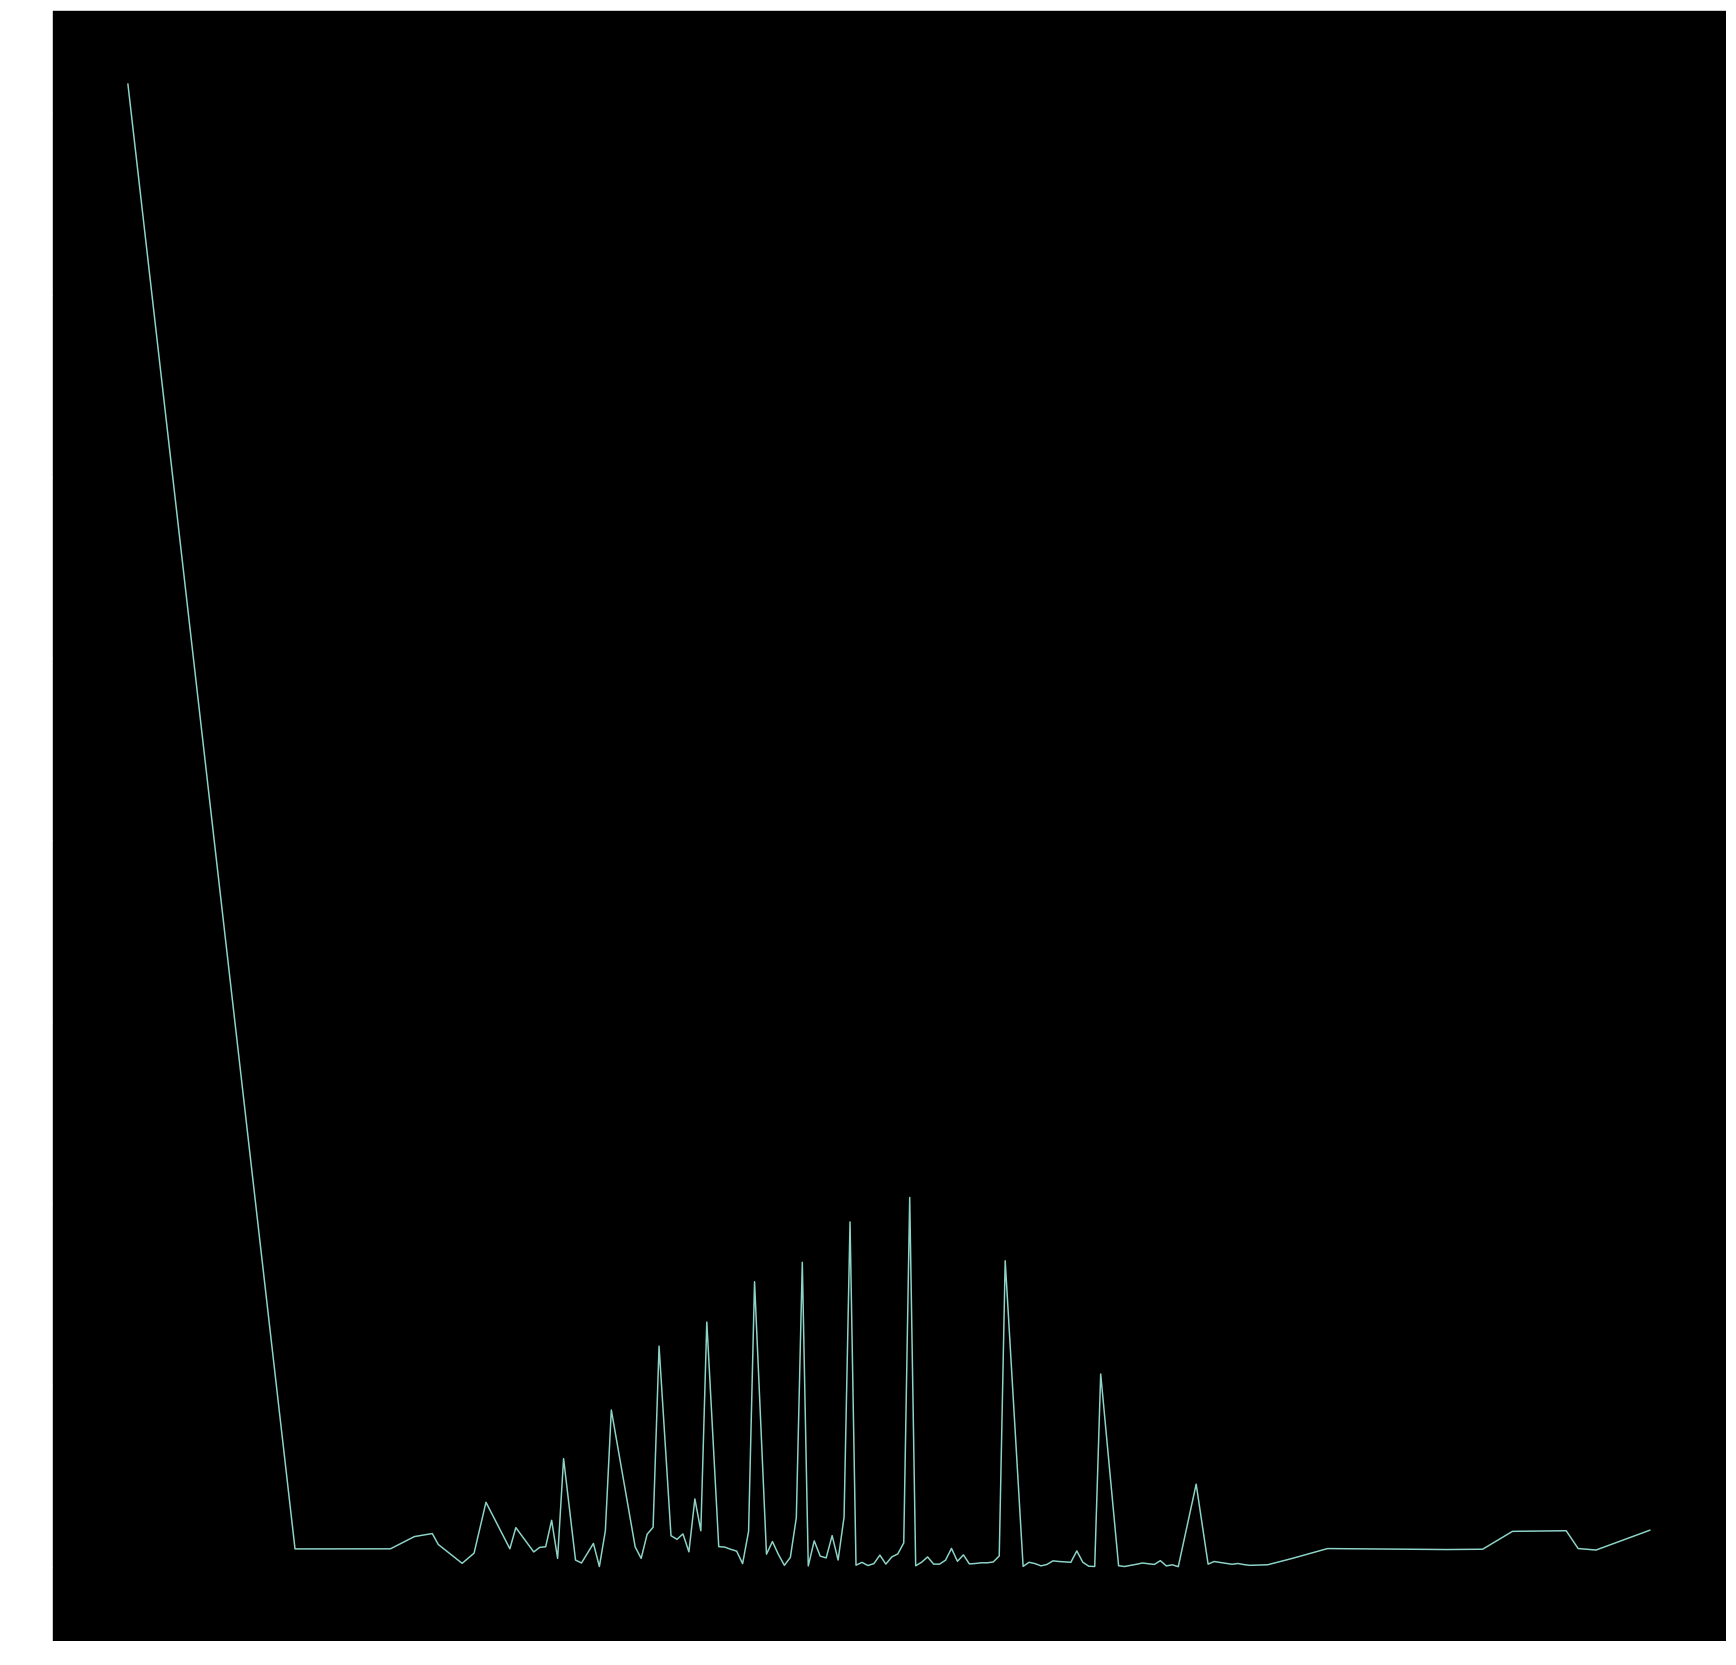

In [105]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(sorted_full_images_modes_values, sorted_full_images_modes_frequencies)
plt.show()